In [1]:
import time
import re
import json
import pandas as pd
import matplotlib.pyplot as plt

# Traslapes

In [2]:
def get_common(results, top):
    common = set(u['href'] for u in results[0]['search_results']['results'][:top])
    for c in results[1:]:
        common.intersection_update(u['href'] for u in c['search_results']['results'][:top])
    return common

def graph_heatmap(resultados, top, only_common=False, save_file=False):
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Crear matriz de coincidencias de href
    coincidencias = {}
    for pais in resultados:
        coincidencias[pais["country"]] = {}
        for pais2 in resultados:
            coincidencias[pais["country"]][pais2["country"]] = 0

    if only_common:
        common = get_common(resultados, top)
        for pais in resultados:
            results1 = [r['href'] for r in pais["search_results"]["results"][:top] if r["href"] in common]
            for pais2 in resultados:
                results2 = [r['href'] for r in pais2["search_results"]["results"][:top] if r["href"] in common]
                for result in results1:
                    for result2 in results2:
                        if (result == result2):
                            coincidencias[pais["country"]][pais2["country"]] += 1
    else:
        for pais in resultados:
            for pais2 in resultados:
                for result in pais["search_results"]["results"][:top]:
                    for result2 in pais2["search_results"]["results"][:top]:
                        if result["href"] == result2["href"]:
                            coincidencias[pais["country"]][pais2["country"]] += 1

    # Crear matriz de coincidencias
    matriz = []
    for pais in coincidencias:
        matriz.append([coincidencias[pais][pais2] for pais2 in coincidencias])

    # Crear heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(matriz, annot=True, fmt="d", xticklabels=coincidencias.keys(), yticklabels=coincidencias.keys(), vmin=0, vmax=top, cmap="YlGnBu_r")
    plt.title("Matriz de coincidencias de resultados de búsqueda de 'Corrupción' (Top {})".format(top))

    # Guardar heatmap
    if save_file:
        plt.savefig("heatmap_violencia.png")

    plt.show()

## Todos los resultados

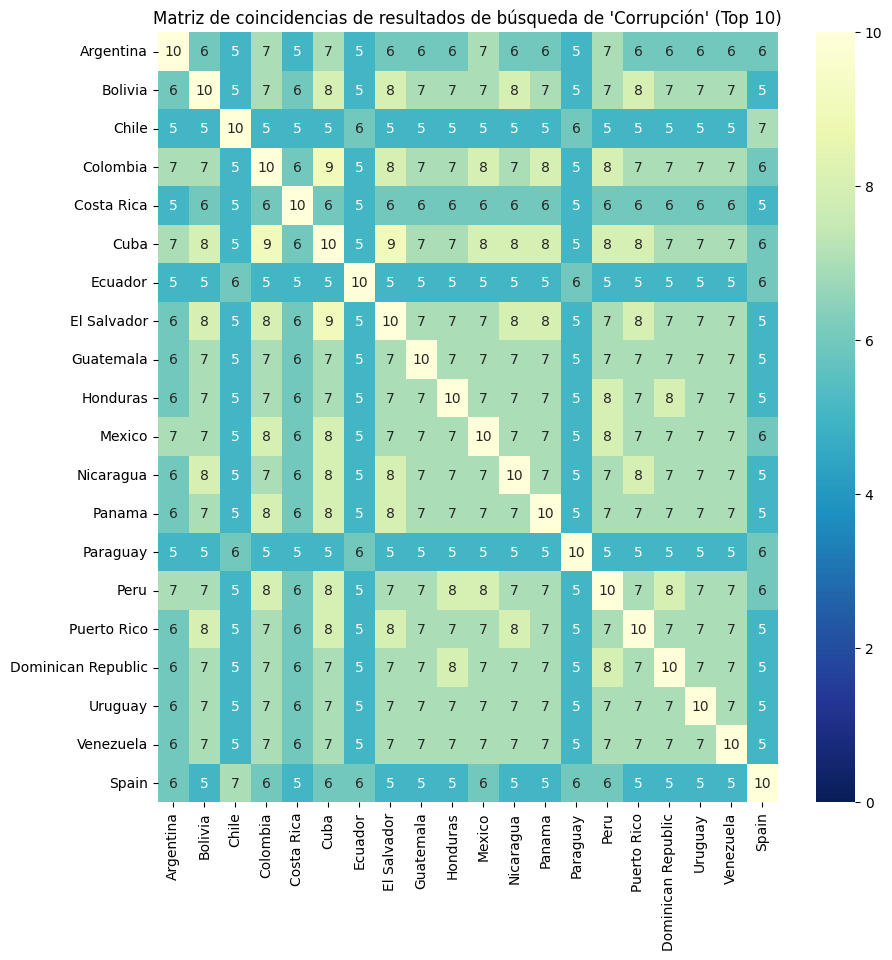

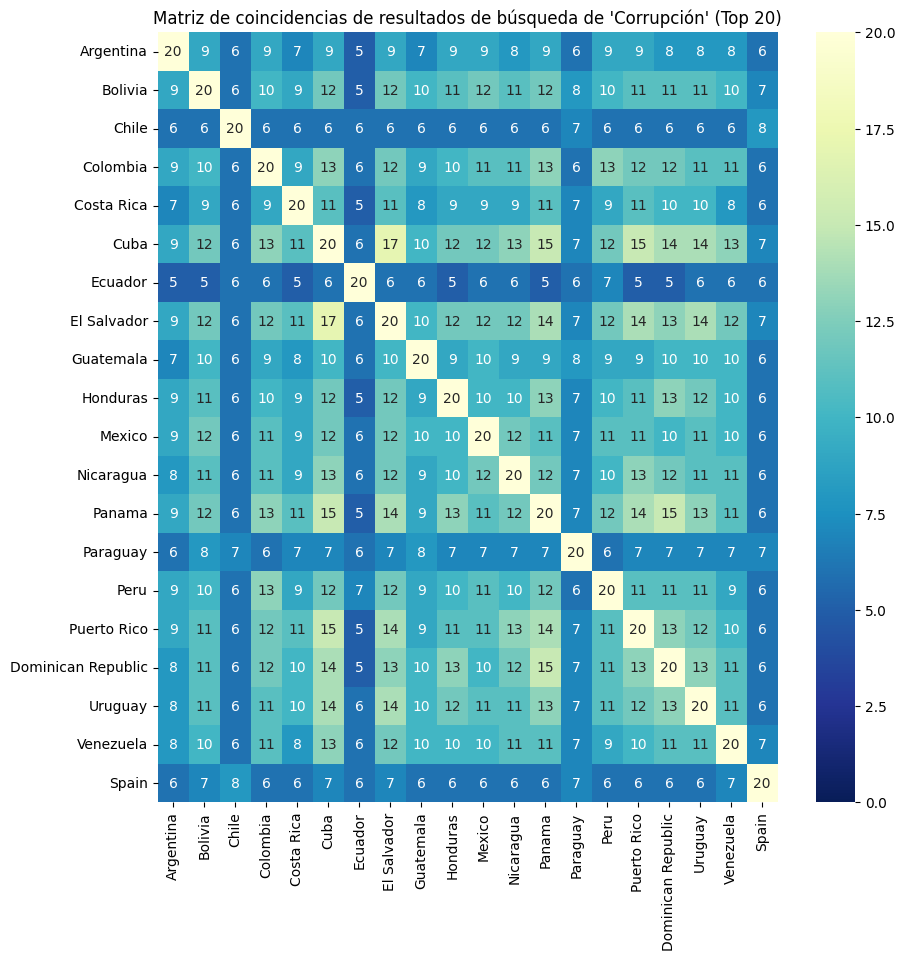

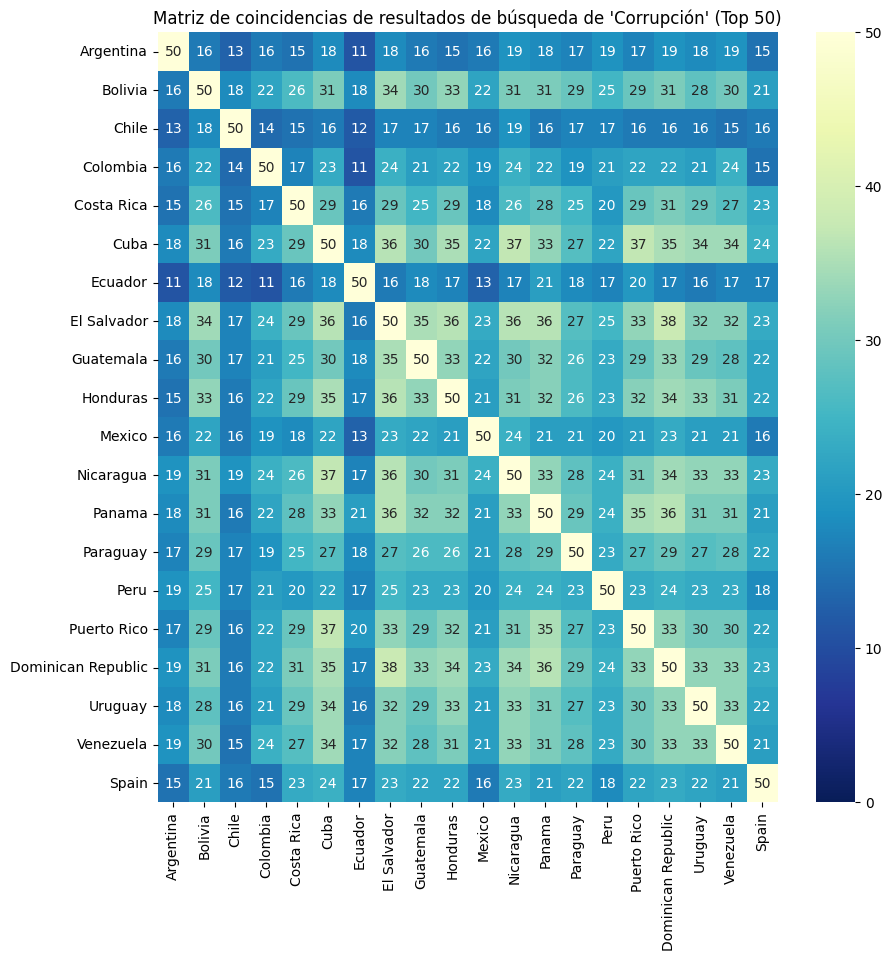

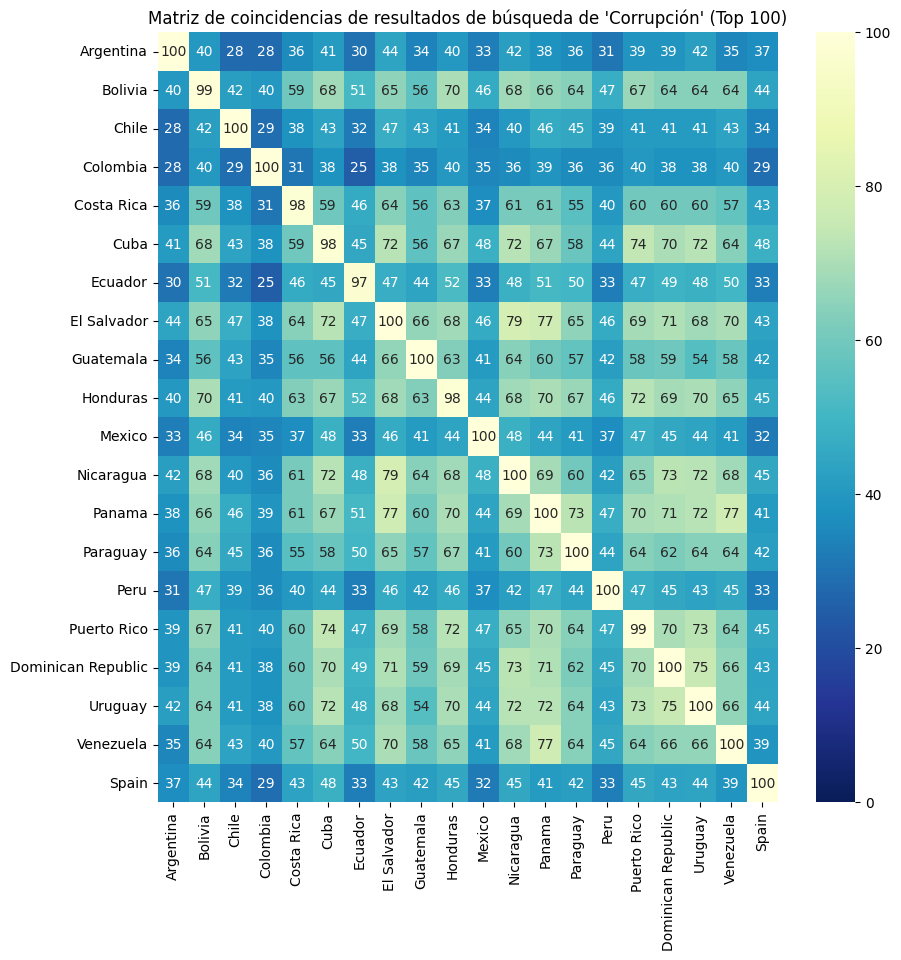

In [3]:
# Leer el archivo JSON guardado
Nombre_Archivo = f"./resultados/resultados_corrupcion.json"

with open(Nombre_Archivo, "r") as file:
    resultados = json.load(file)

graph_heatmap(resultados, 10)
graph_heatmap(resultados, 20)
graph_heatmap(resultados, 50)
graph_heatmap(resultados, 100)

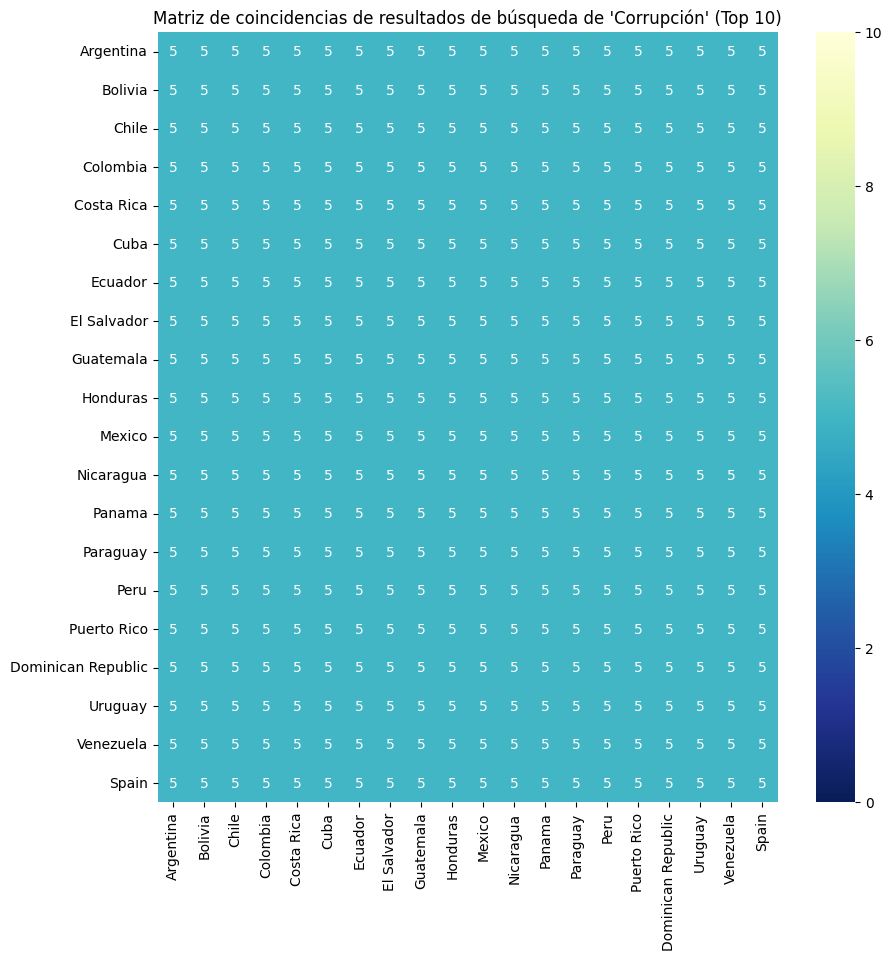

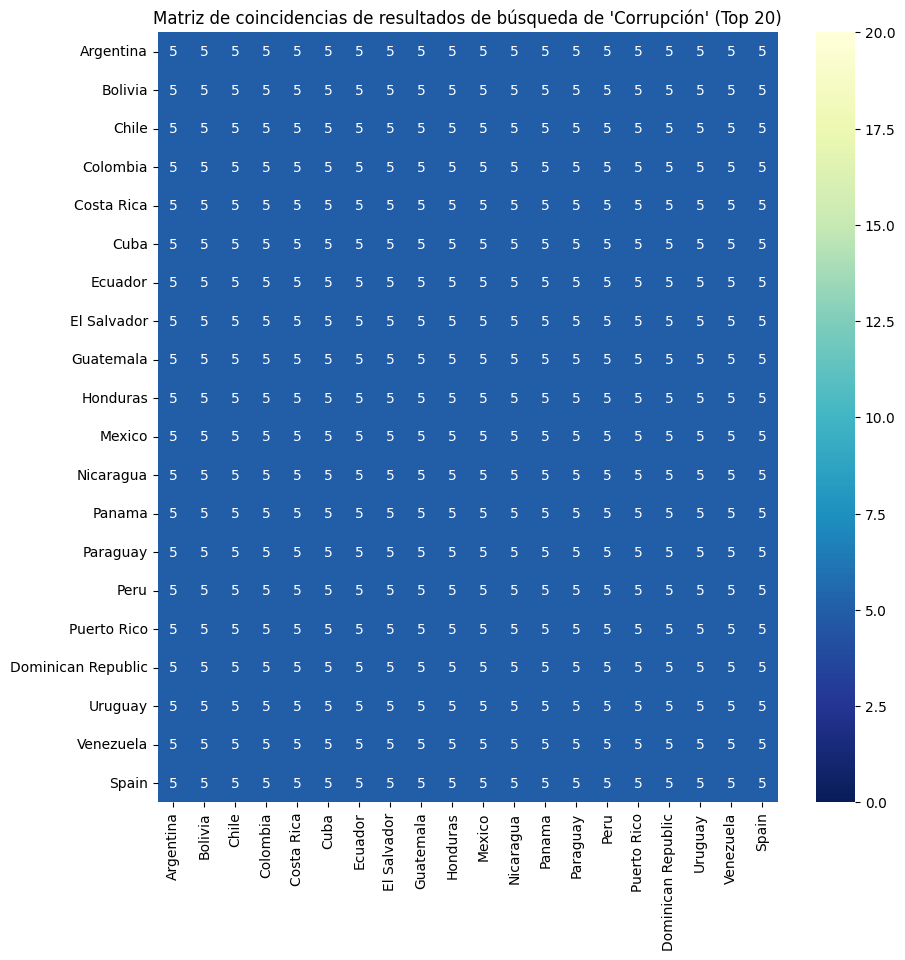

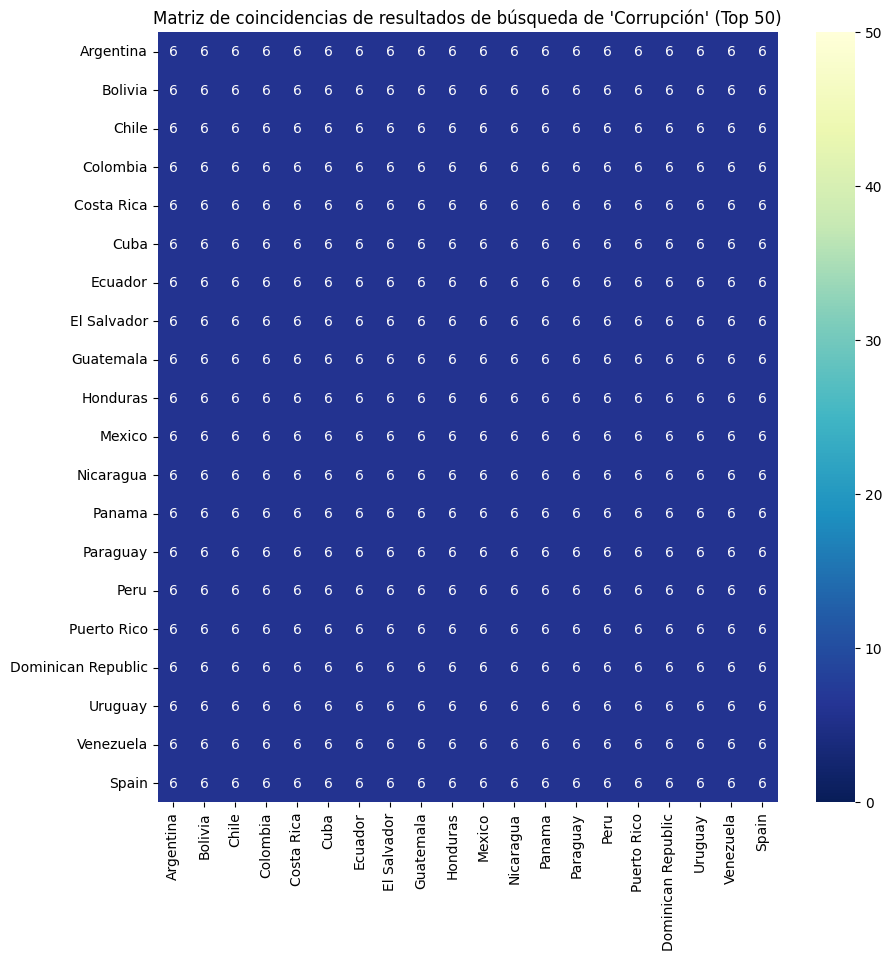

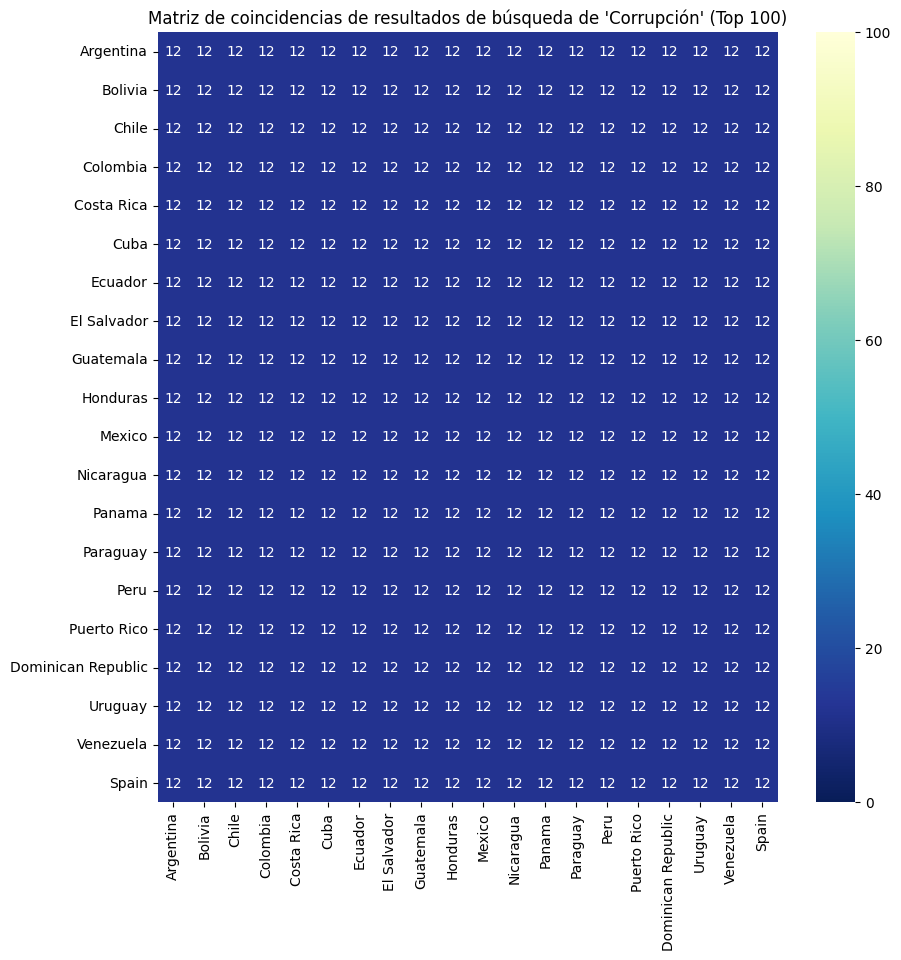

In [4]:
graph_heatmap(resultados, 10, only_common=True)
graph_heatmap(resultados, 20, only_common=True)
graph_heatmap(resultados, 50, only_common=True)
graph_heatmap(resultados, 100, only_common=True)

# Correlaciones

In [5]:
# Leer el archivo JSON guardado
Nombre_Archivo = f"./resultados/res_unicos_corrupcion.json"

with open(Nombre_Archivo, "r") as file:
    all_hrefs = json.load(file)

In [6]:
import pandas as pd
from math import isnan
from scipy.stats import kendalltau, spearmanr

def build_aligned_ranks(rank_list, universe, top, absent_policy="max_plus_one"):
    """
    rank_list: lista de dicts con clave 'href', en orden de ranking.
    universe: lista/iterable con todos los hrefs a alinear.
    top: entero, cuántos tomas de rank_list.
    absent_policy:
      - 'max_plus_one': rank = len(universe) + 1 a los ausentes
      - '1.5top': rank = int(1.5 * top) a los ausentes
    """
    pos = {item['href']: i+1 for i, item in enumerate(rank_list)}  # 1..len(list)
    if absent_policy == "max_plus_one":
        absent_rank = len(universe) + 1
    elif absent_policy == "1.5top":
        absent_rank = int(1.5 * top)
    else:
        absent_rank = len(universe) + 1
    return [pos.get(u, absent_rank) for u in universe]

def correlation_matrix(results, universe, top, method="spearman", absent_policy="max_plus_one", only_common=False, common_by_order=False):
    """
    results: lista de dicts con llaves ["country"] y ["search_results"]["results"]
    method: "spearman" (rho) o "kendall" (tau-b)
    absent_policy:
      - 'max_plus_one': rank = len(universe) + 1 a los ausentes
      - '1.5top': rank = int(1.5 * top) a los ausentes
    only_common: si True, solo usa los resultados comunes a todos los países
    common_by_order: si True y only_common es True, alinea los rankings según el orden común,
                  si False (default), usa las posiciones de los elementos comunes en el ranking original
    """
    
    countries = [c["country"] for c in results]

    if only_common:
        common_universe = [u for u in universe if u in get_common(results, top)]
        aligned = {}
        for i in common_universe:
            print(i)
        if common_by_order:
            for c in results:
                common = [r for r in c["search_results"]["results"][:top] if r["href"] in common_universe]
                if (c["country"]=='Bolivia') or c["country"]=='Spain':
                    print("Common for {}:".format(c["country"]))
                    for r in common:
                        print("\t{}".format(r['href']))
                aligned[c["country"]] = build_aligned_ranks(
                        common, common_universe, top, absent_policy=absent_policy
                    )
        else:
            for c in results:
                top_list = c['search_results']['results'][:top]
                pos = {item['href']: i+1 for i, item in enumerate(top_list)}  # 1..len(list)
                aligned[c["country"]] = [pos[u] for u in common_universe]

    else:
        aligned = {
            c["country"]: build_aligned_ranks(
                c["search_results"]["results"][:top], universe, top, absent_policy=absent_policy
            )
            for c in results
        }

    corr_data, pval_data = [], []
    for c1 in countries:
        row_corr, row_p = [], []
        x = aligned[c1]
        for c2 in countries:
            y = aligned[c2]
            if method == "spearman":
                r, p = spearmanr(x, y)
            elif method == "kendall":
                r, p = kendalltau(x, y)
            else:
                raise ValueError("method debe ser 'spearman' o 'kendall'")
            row_corr.append(0.0 if (r is None or isnan(r)) else float(r))
            row_p.append(1.0 if (p is None or isnan(p)) else float(p))
        corr_data.append(row_corr)
        pval_data.append(row_p)

    corr_df = pd.DataFrame(corr_data, index=countries, columns=countries)
    p_df    = pd.DataFrame(pval_data, index=countries, columns=countries)
    return corr_df, p_df, aligned


## Todos los resultados

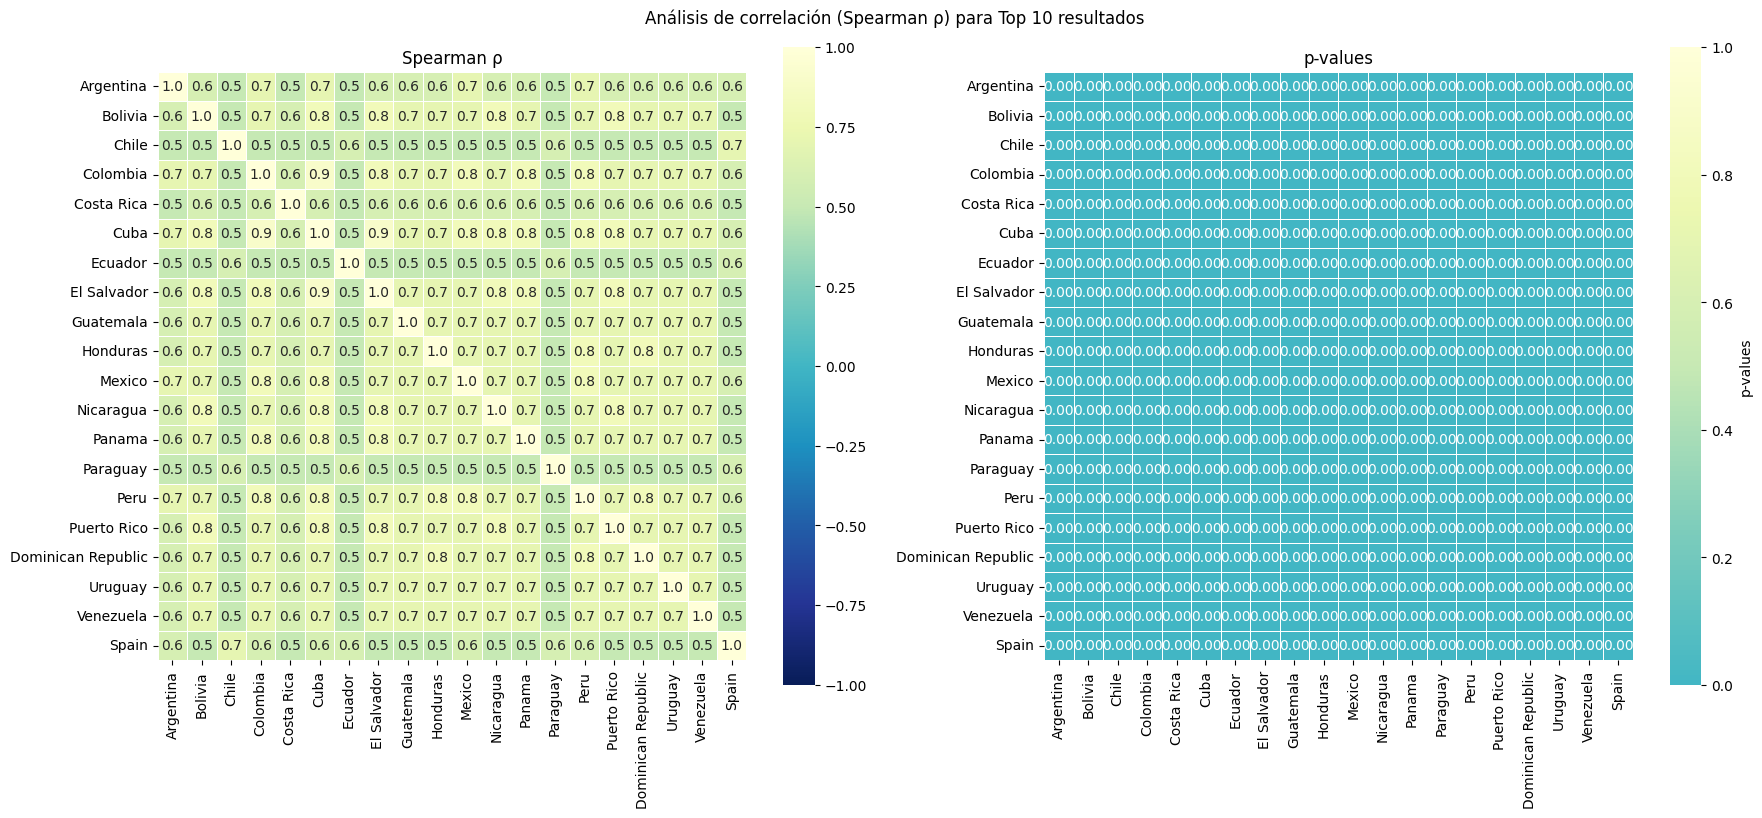

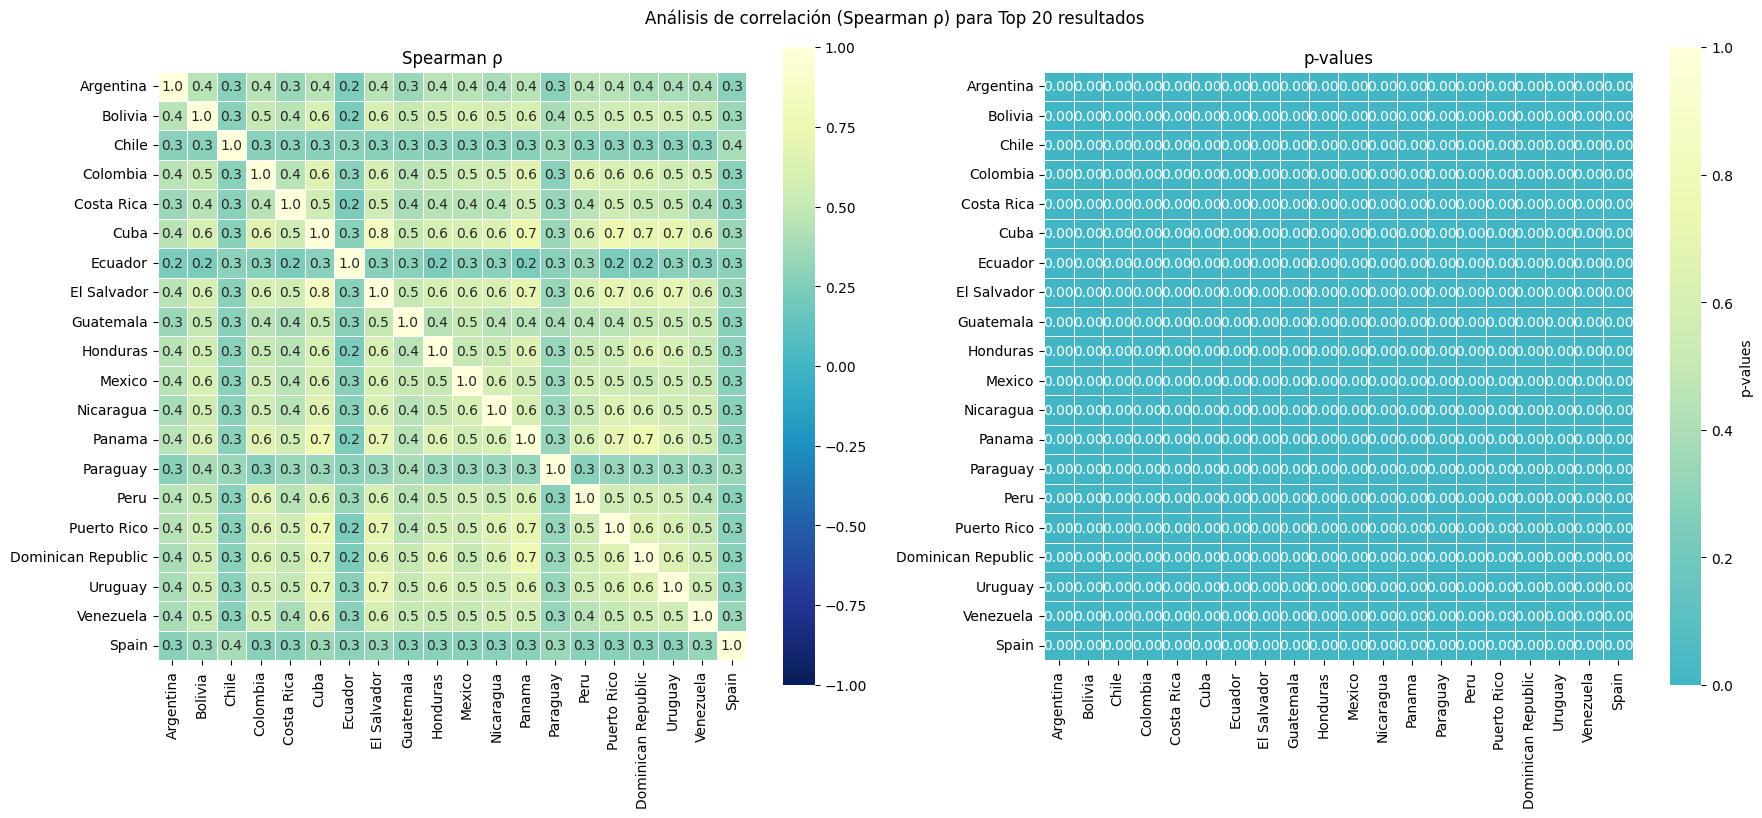

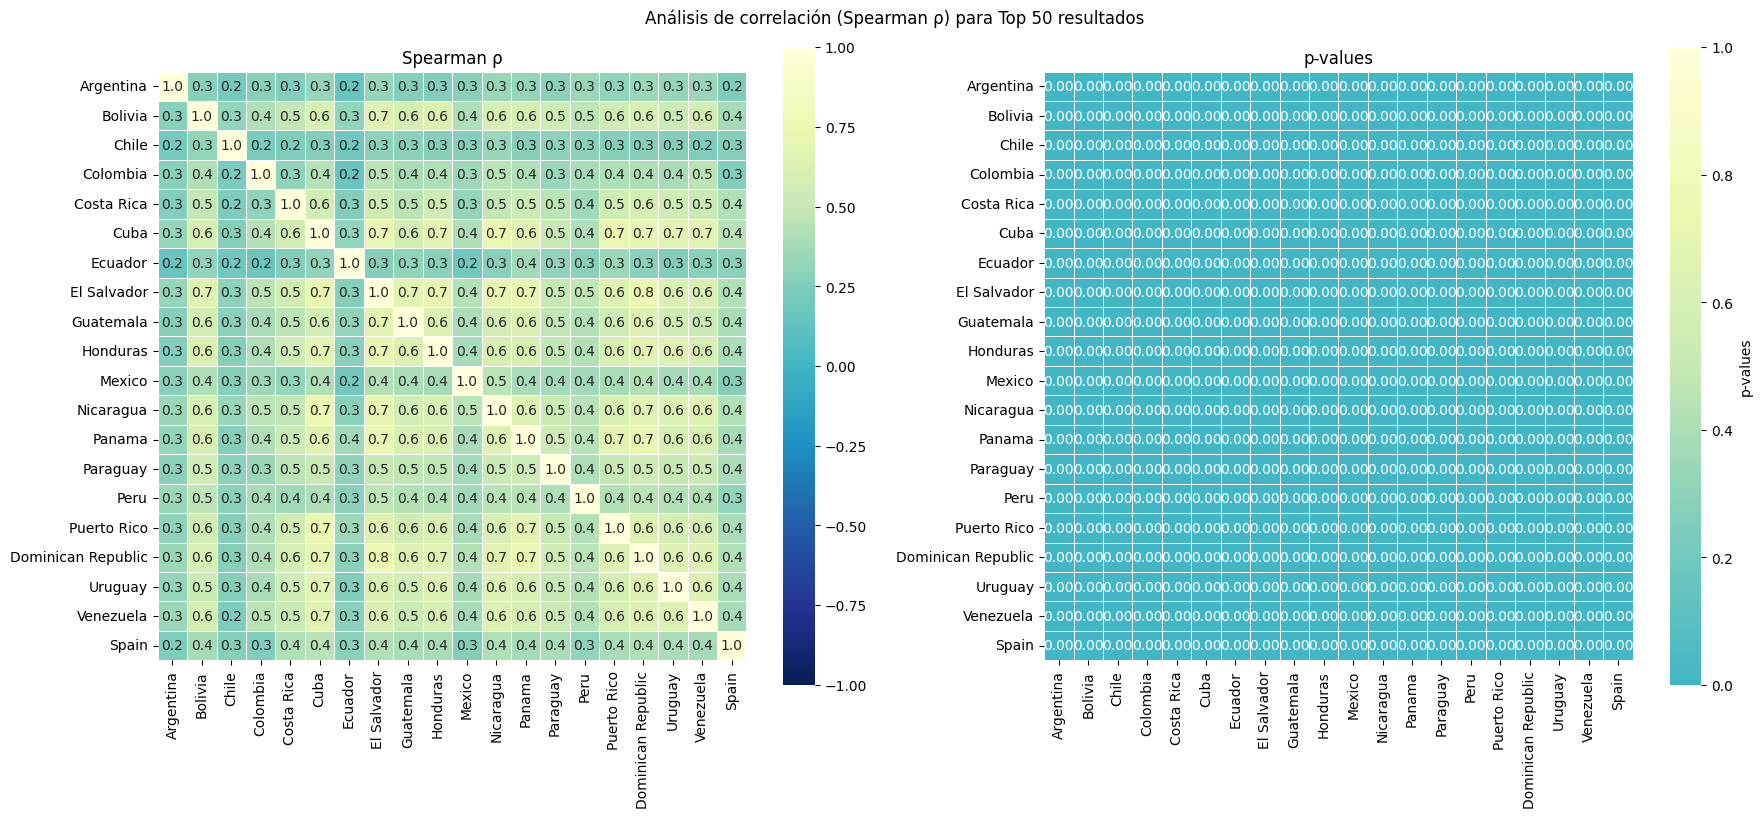

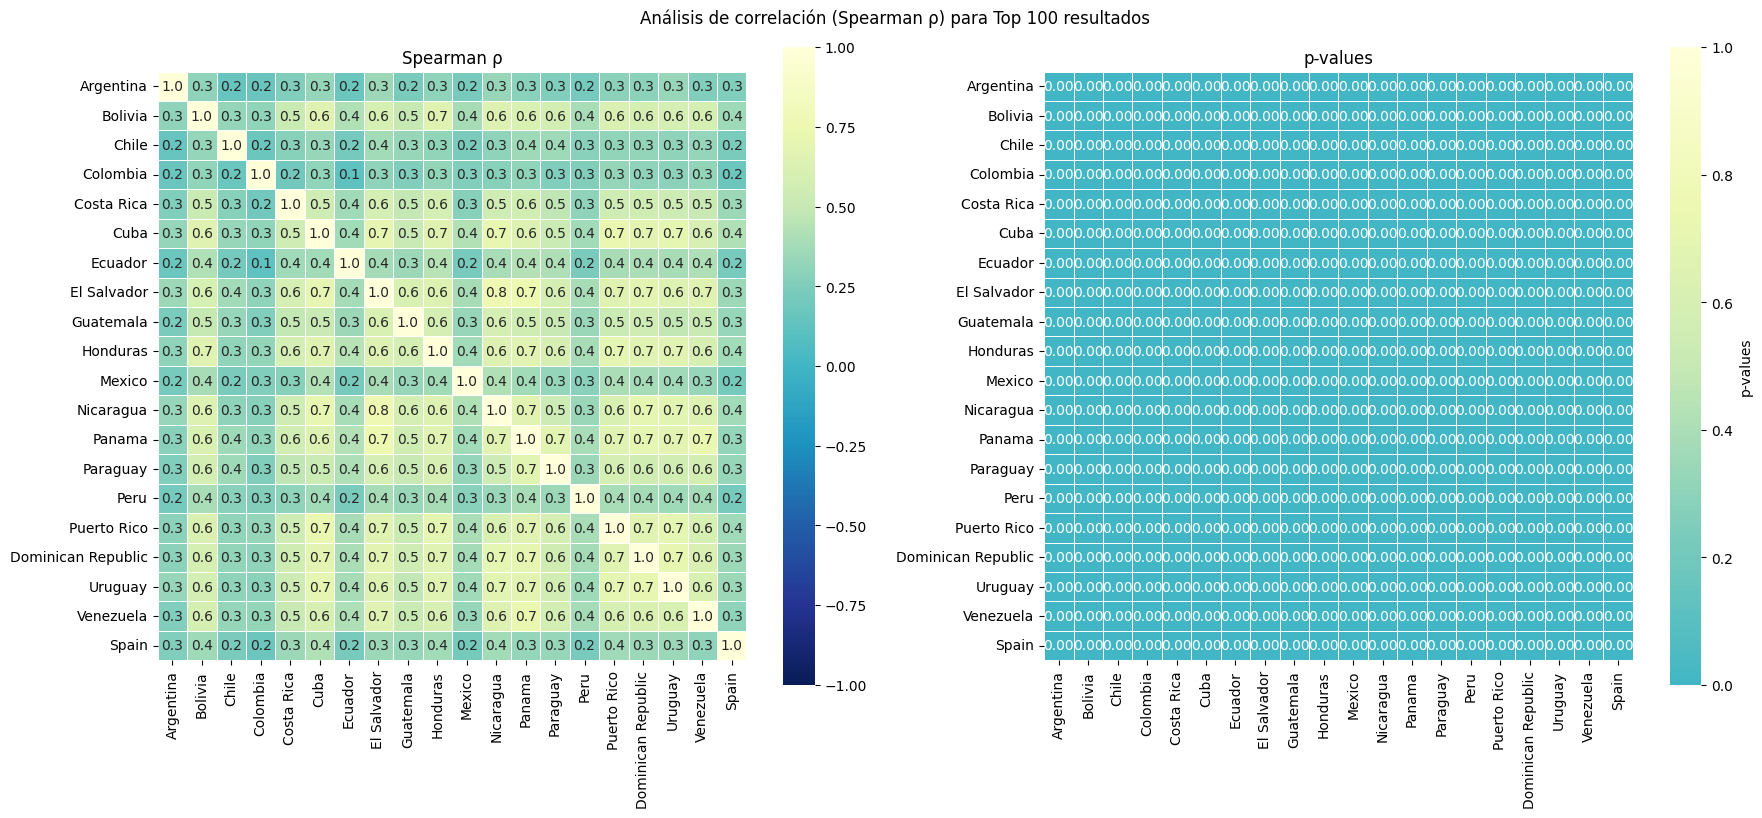

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

method = "spearman"  # "spearman" o "kendall"

for top in [10, 20, 50, 100]:
    rho, p, aligned = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top")

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
    cbar_kws={"label": method_dict[method]}

    # Heatmap method
    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", vmin=-1, vmax=1, linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )

    axes[0].set_title(method_dict[method])

    # Heatmap p-values
    sns.heatmap(
        p, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".2f", vmin=0, vmax=1, linewidths=0.5, square=True,
        cbar_kws={"label": "p-values"}, ax=axes[1]
    )
    axes[1].set_title("p-values")

    plt.suptitle(f"Análisis de correlación ({method_dict[method]}) para Top {top} resultados")
    plt.tight_layout()
    plt.show()


## Resultados comunes
### Por orden

https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html
Common for Bolivia:
	https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
	https://www.interpol.int/es/Delitos/Corrupcion
	https://www.unodc.org/newsletter/es/200601/page004.html
	https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
	https://dle.rae.es/corrupci%C3%B3n
Common for Spain:
	https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
	https://dle.rae.es/corrupci%C3%B3n
	https://es.wikip

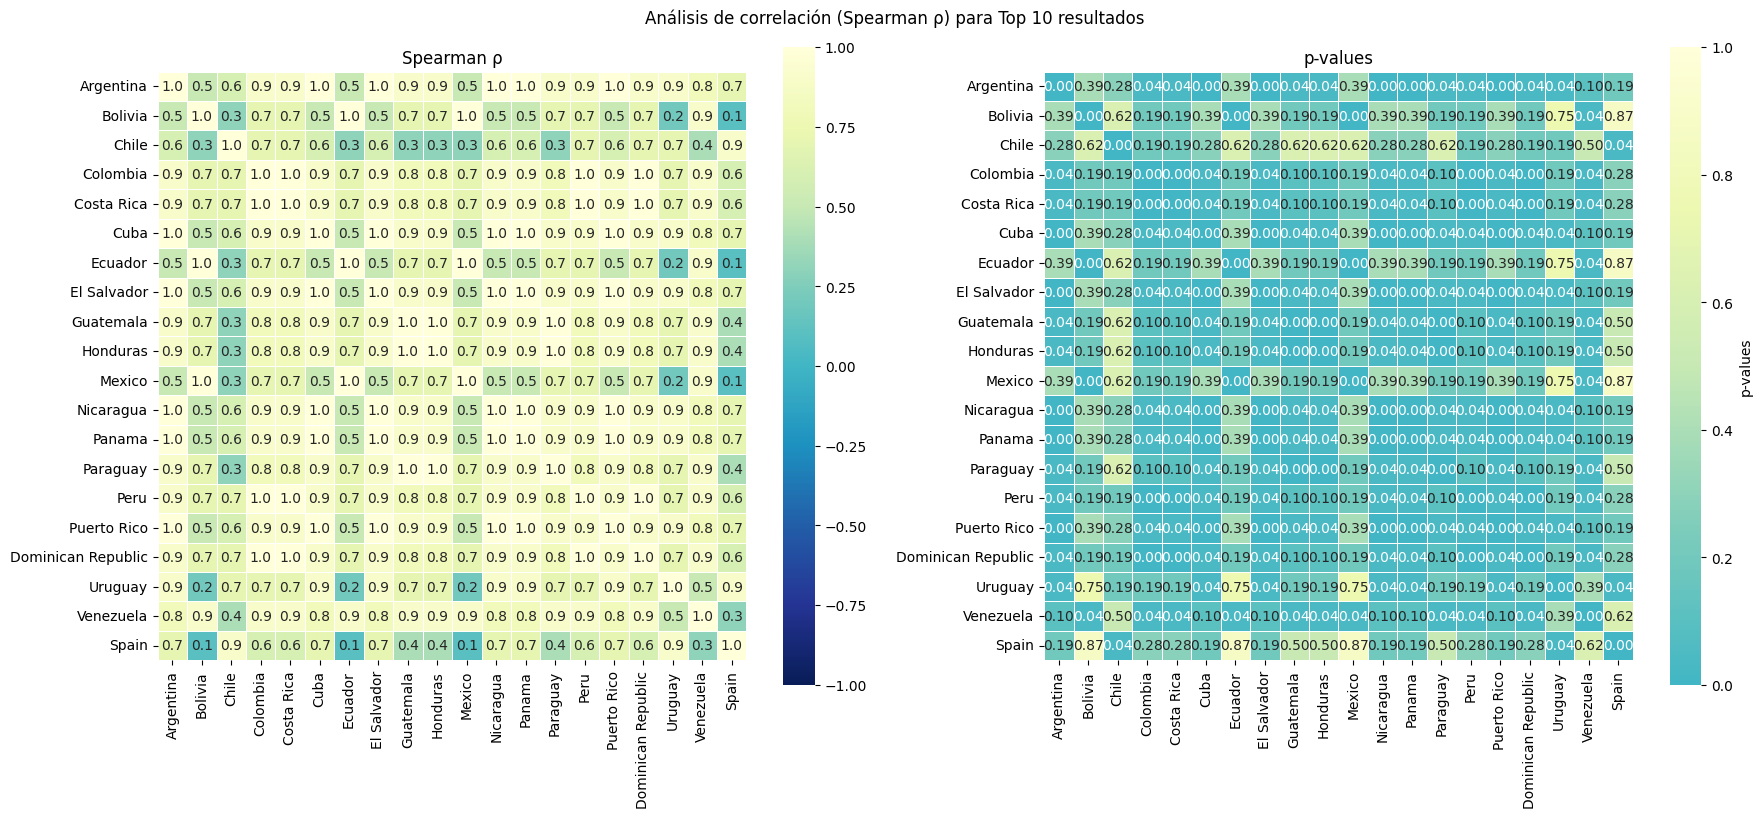

https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html
Common for Bolivia:
	https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
	https://www.interpol.int/es/Delitos/Corrupcion
	https://www.unodc.org/newsletter/es/200601/page004.html
	https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
	https://dle.rae.es/corrupci%C3%B3n
Common for Spain:
	https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
	https://dle.rae.es/corrupci%C3%B3n
	https://es.wikip

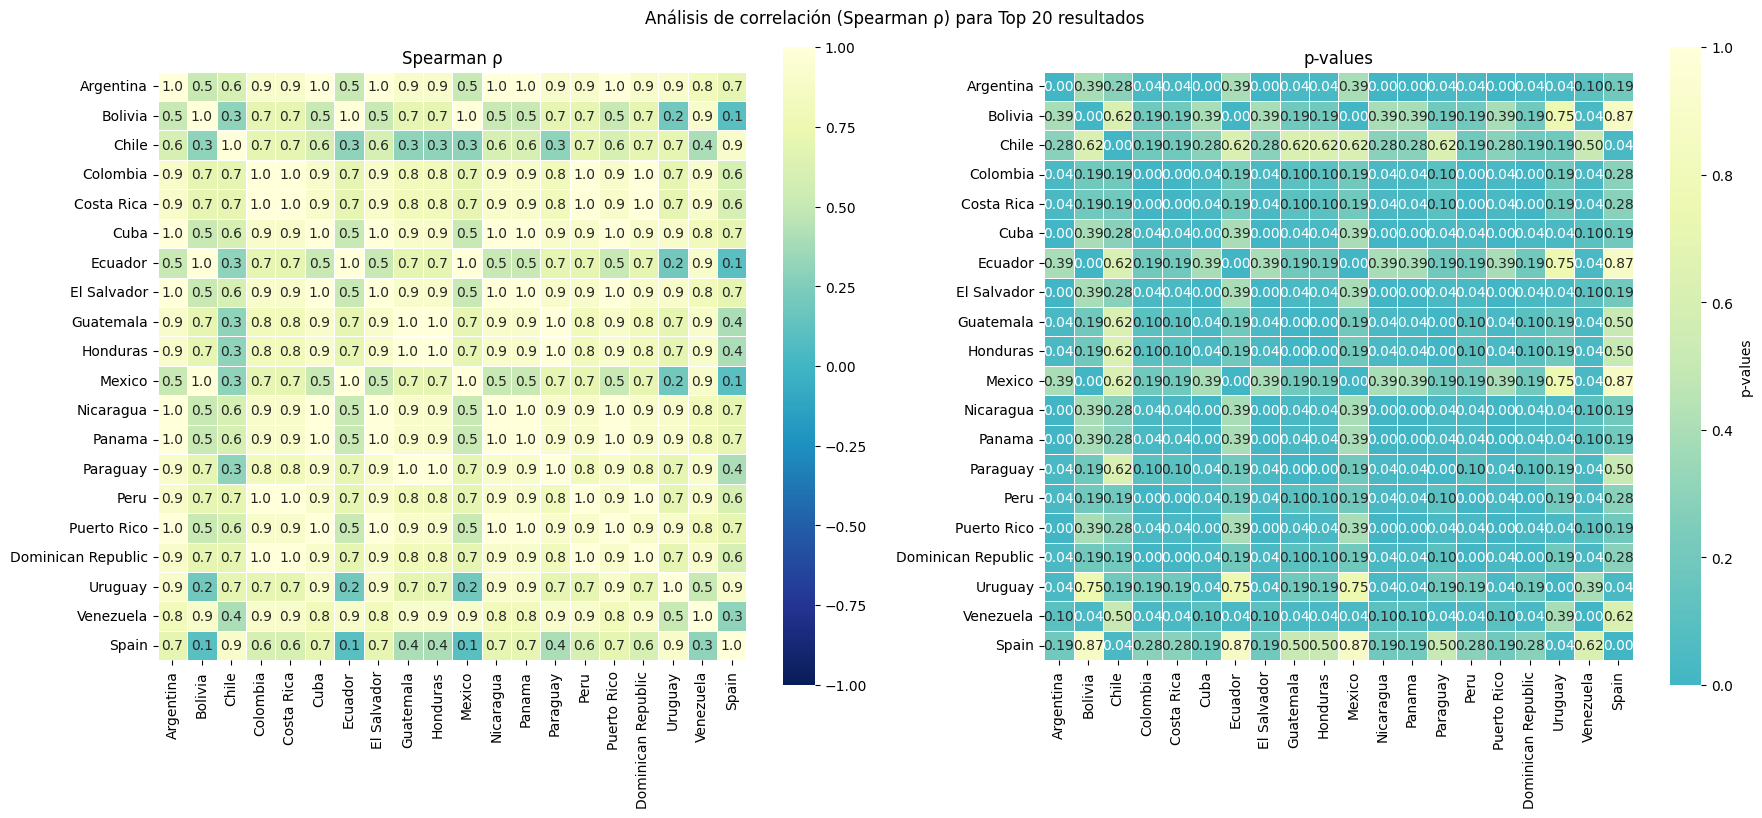

https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html
https://dpej.rae.es/lema/corrupci%C3%B3n
Common for Bolivia:
	https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
	https://www.interpol.int/es/Delitos/Corrupcion
	https://www.unodc.org/newsletter/es/200601/page004.html
	https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
	https://dle.rae.es/corrupci%C3%B3n
	https://dpej.rae.es/lema/corrupci%C3%B3n
Common for Spain:
	https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20s

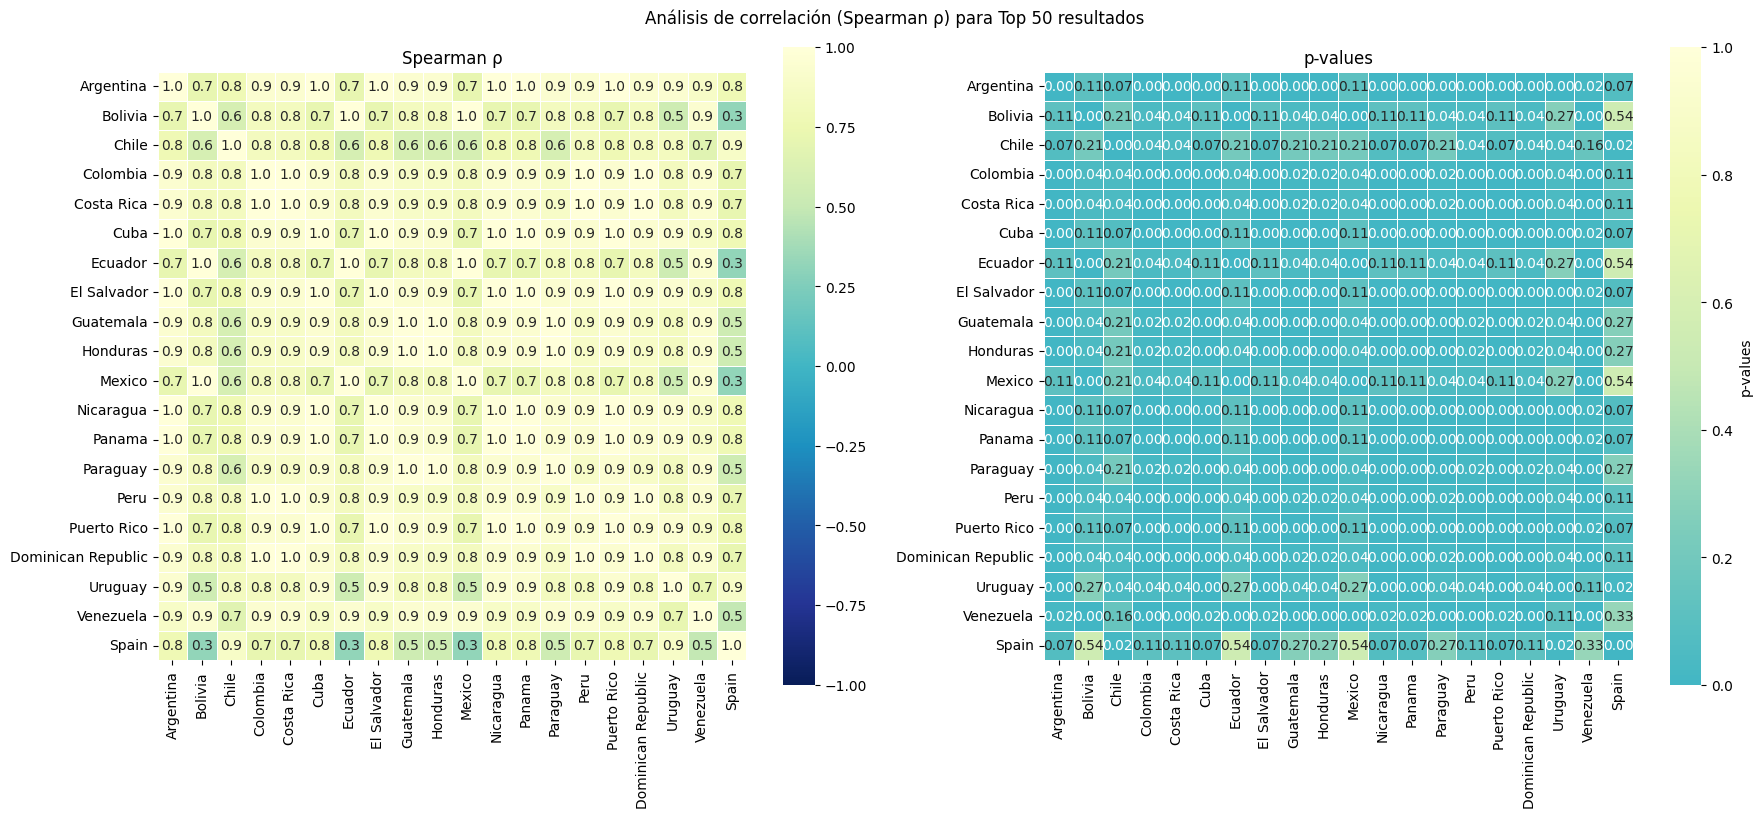

https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html
https://www.youtube.com/watch?v=Be3q1GSMhf8
https://www.ohchr.org/es/good-governance/corruption-and-human-rights
https://dpej.rae.es/lema/corrupci%C3%B3n
https://elpais.com/noticias/corrupcion/
https://publications.iadb.org/publications/spanish/document/Corrupci%C3%B3n-normal-y-corrupci%C3%B3n-sist%C3%A9mica.pdf
https://cnc.gob.gt/
https://www.unir.net/revista/derecho/que-es-corrupcion/
Common for Bolivia:
	https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
	https://www.interpol.int/es/Delitos/Corrupcion
	http

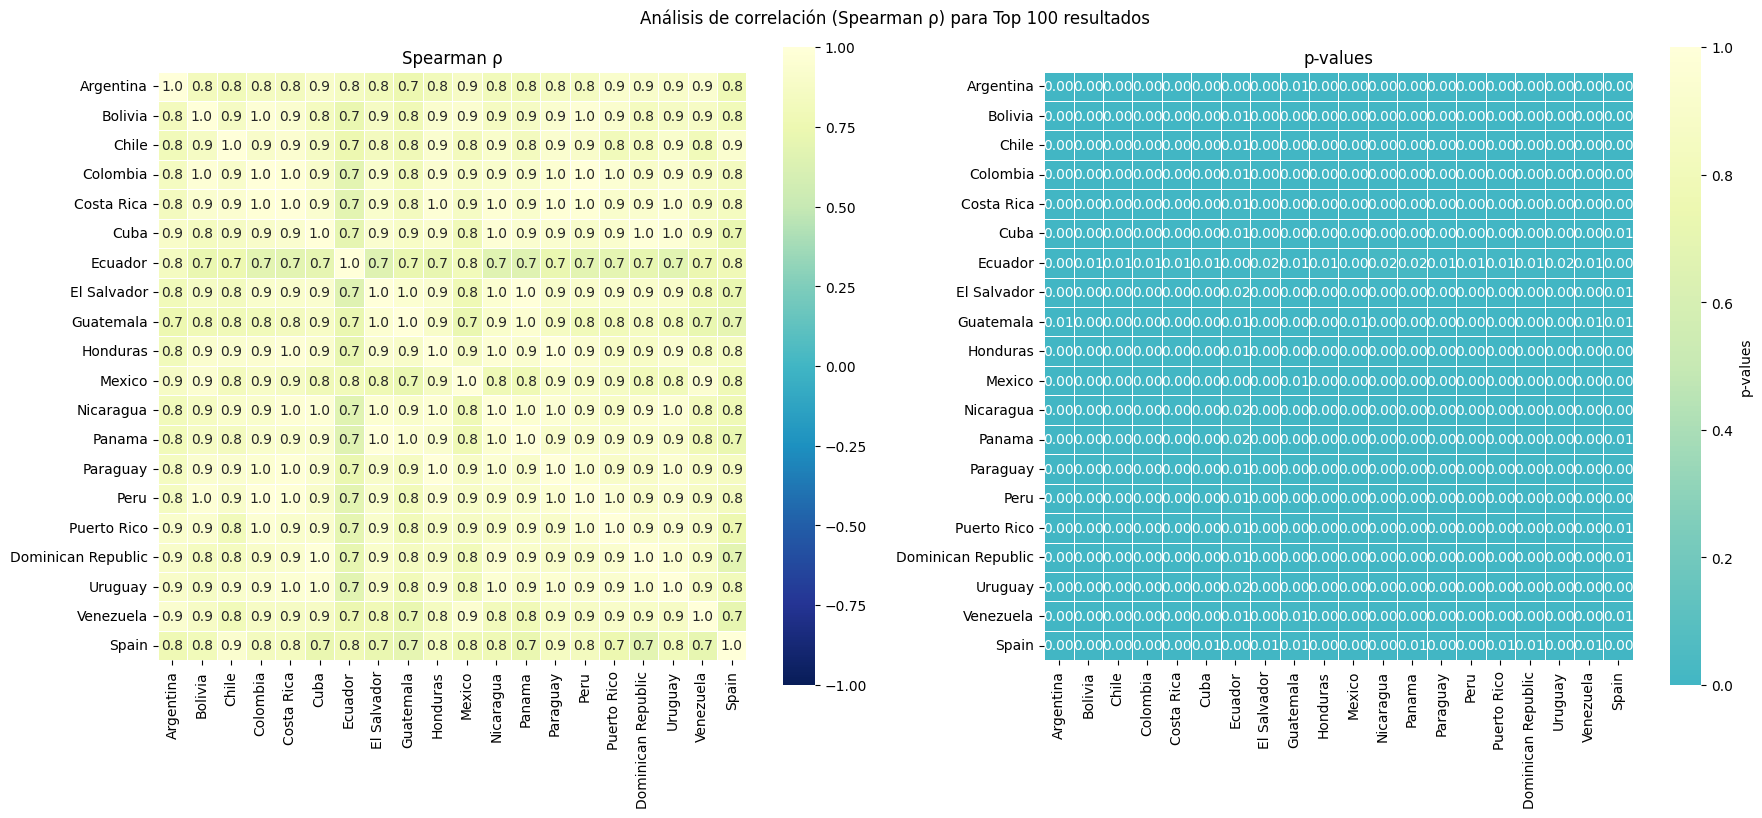

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

method = "spearman"  # "spearman" o "kendall"

for top in [10, 20, 50, 100]:
    if top == 10:
        rho, p, aligned = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top", only_common=True, common_by_order=True)
    else:
        rho, p, _ = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top", only_common=True, common_by_order=True)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
    cbar_kws={"label": method_dict[method]}

    # Heatmap method
    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", vmin=-1, vmax=1, linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )

    axes[0].set_title(method_dict[method])

    # Heatmap p-values
    sns.heatmap(
        p, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".2f", vmin=0, vmax=1, linewidths=0.5, square=True,
        cbar_kws={"label": "p-values"}, ax=axes[1]
    )
    axes[1].set_title("p-values")

    plt.suptitle(f"Análisis de correlación ({method_dict[method]}) para Top {top} resultados")
    plt.tight_layout()
    plt.show()


In [9]:
aligned

{'Argentina': [1, 2, 3, 4, 5],
 'Bolivia': [1, 4, 2, 5, 3],
 'Chile': [1, 4, 3, 2, 5],
 'Colombia': [1, 3, 2, 4, 5],
 'Costa Rica': [1, 3, 2, 4, 5],
 'Cuba': [1, 2, 3, 4, 5],
 'Ecuador': [1, 4, 2, 5, 3],
 'El Salvador': [1, 2, 3, 4, 5],
 'Guatemala': [1, 2, 3, 5, 4],
 'Honduras': [1, 2, 3, 5, 4],
 'Mexico': [1, 4, 2, 5, 3],
 'Nicaragua': [1, 2, 3, 4, 5],
 'Panama': [1, 2, 3, 4, 5],
 'Paraguay': [1, 2, 3, 5, 4],
 'Peru': [1, 3, 2, 4, 5],
 'Puerto Rico': [1, 2, 3, 4, 5],
 'Dominican Republic': [1, 3, 2, 4, 5],
 'Uruguay': [1, 2, 4, 3, 5],
 'Venezuela': [1, 3, 2, 5, 4],
 'Spain': [1, 3, 4, 2, 5]}

In [10]:
print("Top de {}".format(resultados[1]["country"]))
for i in resultados[1]['search_results']['results'][:10]:
    print(i['href'])

Top de Bolivia
https://es.wikipedia.org/wiki/Ley
https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://www.interpol.int/es/Delitos/Corrupcion
https://www.unodc.org/newsletter/es/200601/page004.html
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://dle.rae.es/corrupci%C3%B3n
https://www.ohchr.org/es/good-governance/corruption-and-human-rights
https://www.bcb.gob.bo/webdocs/transparenciadocs/CARTILLA%20BCB%20FINAL%20WEB.pdf
http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S2448-51362023000200265
https://www.planificacion.gob.bo/uploads/normativa/A_DS214_123ESP.pdf


In [11]:
print("Top de {}".format(resultados[-1]["country"]))
for i in resultados[-1]['search_results']['results'][:10]:
    print(i['href'])

Top de Spain
https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_(abuso_de_poder)
https://dle.rae.es/corrupci%C3%B3n
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dpej.rae.es/lema/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html
https://www.redeia.com/es/gobierno-corporativo/etica-y-cumplimiento/prevencion-de-la-corrupcion
https://revistasonline.inap.es/index.php/GAPP/article/view/260/260
https://www.un.org/es/observances/anti-corruption-day


### Por posicion

https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html


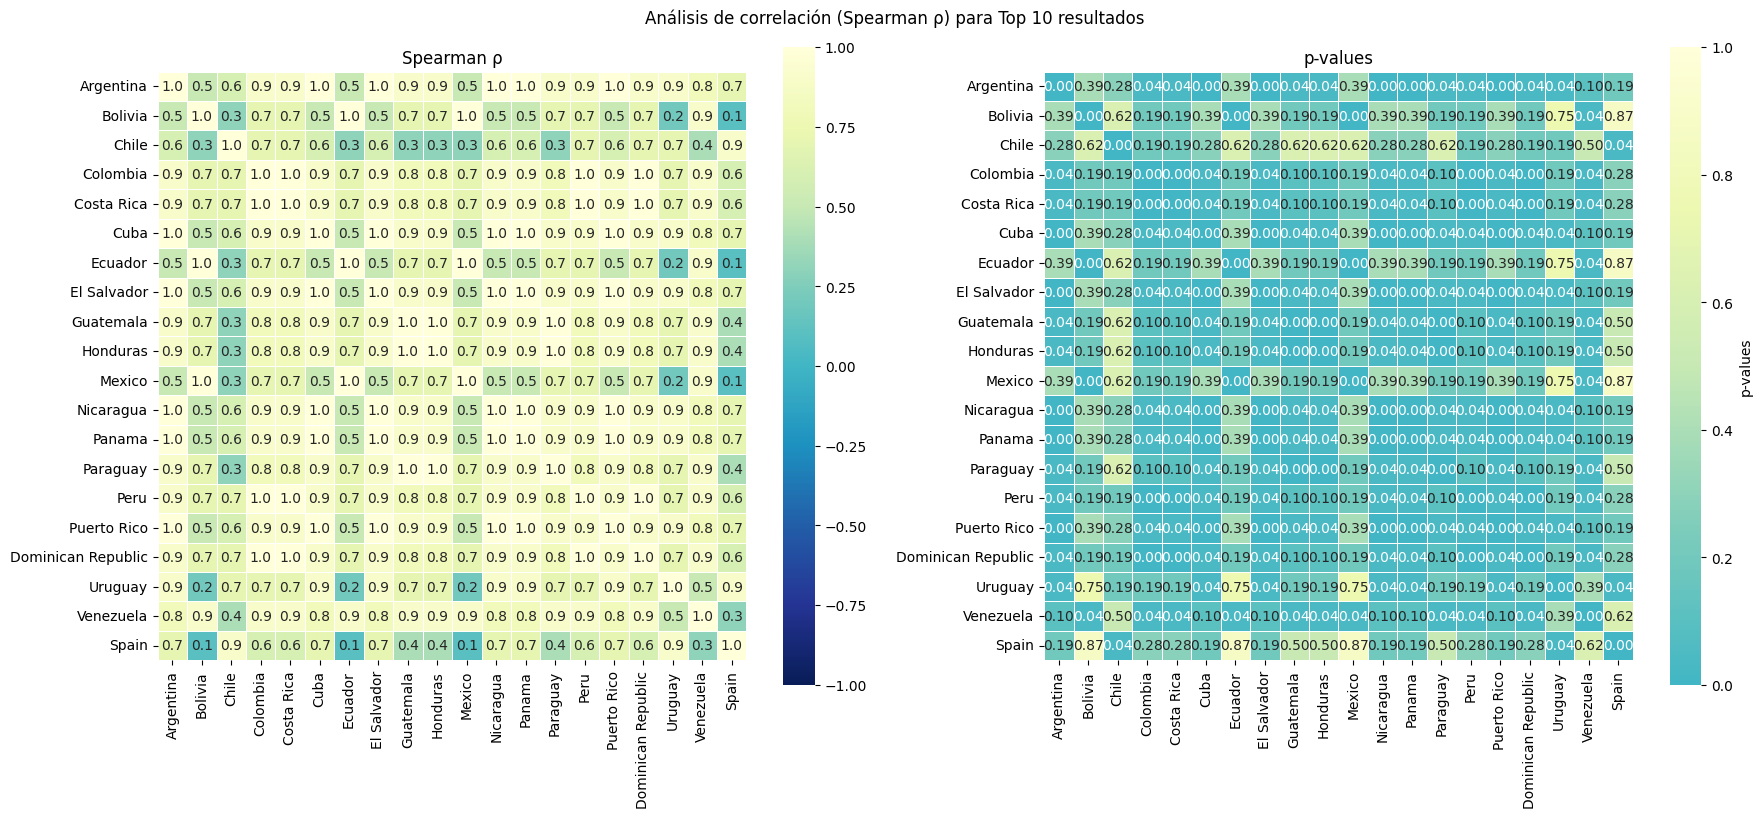

https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html


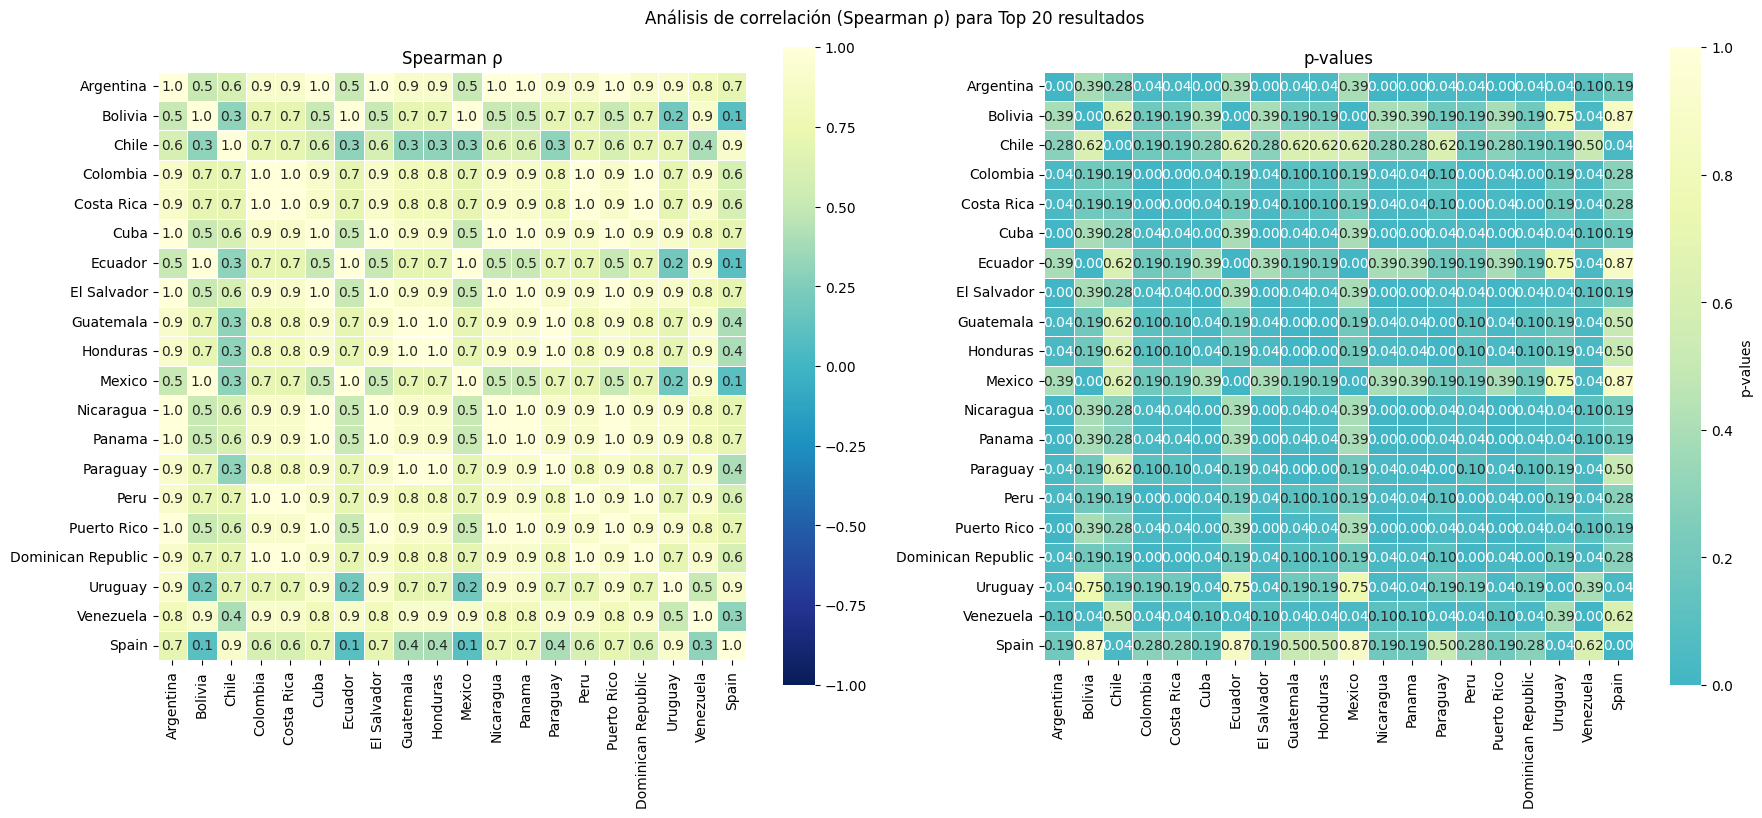

https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html
https://dpej.rae.es/lema/corrupci%C3%B3n


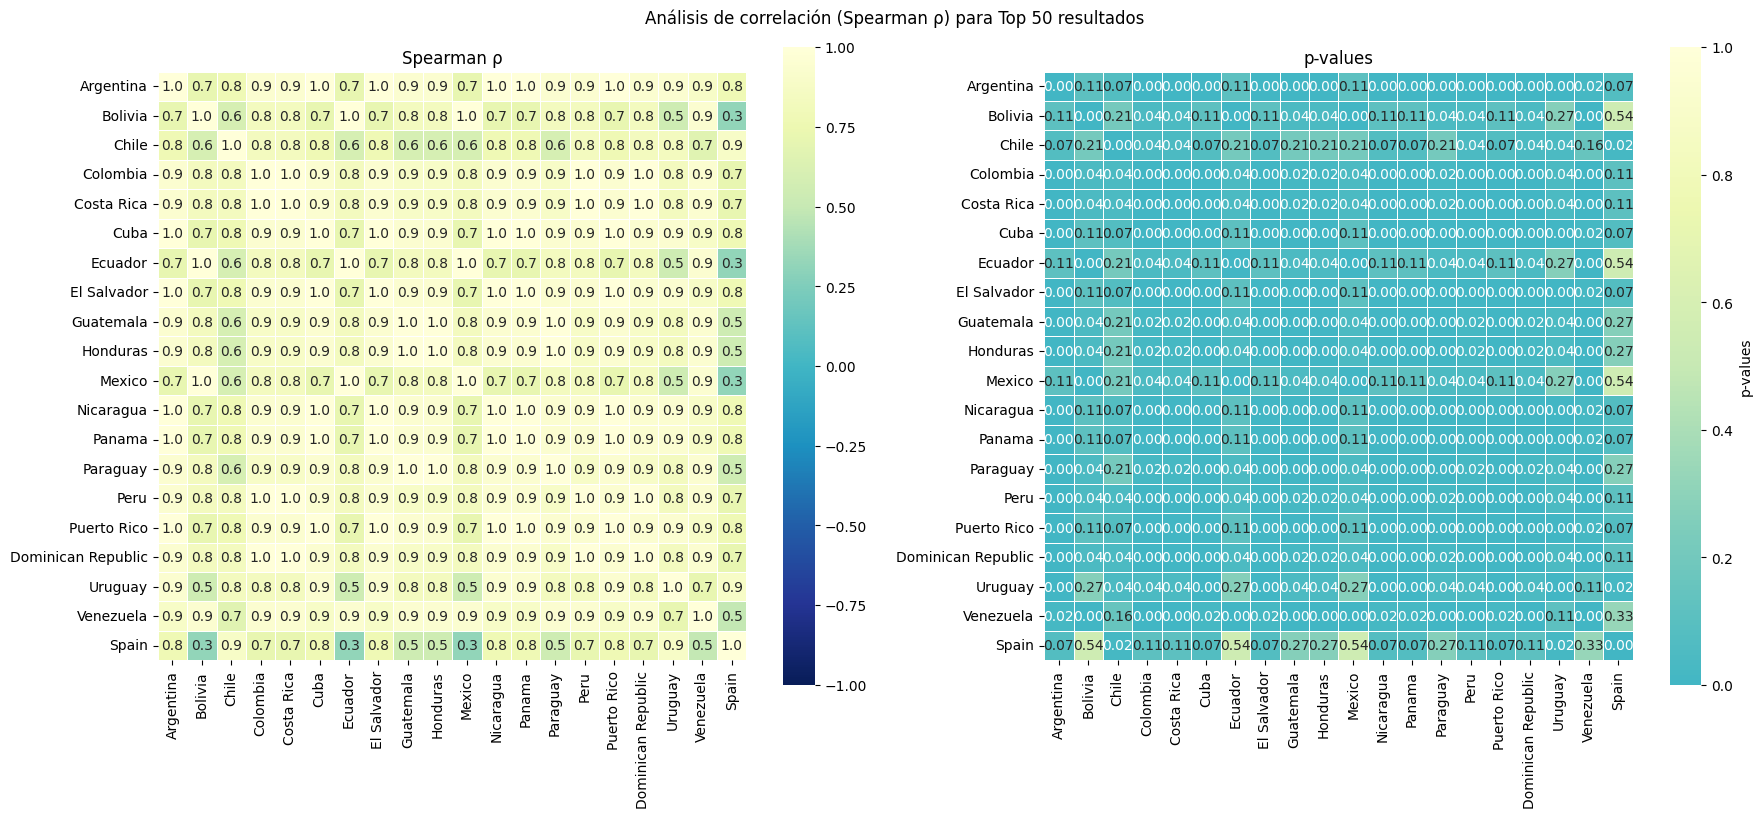

https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html
https://www.youtube.com/watch?v=Be3q1GSMhf8
https://www.ohchr.org/es/good-governance/corruption-and-human-rights
https://dpej.rae.es/lema/corrupci%C3%B3n
https://elpais.com/noticias/corrupcion/
https://publications.iadb.org/publications/spanish/document/Corrupci%C3%B3n-normal-y-corrupci%C3%B3n-sist%C3%A9mica.pdf
https://cnc.gob.gt/
https://www.unir.net/revista/derecho/que-es-corrupcion/


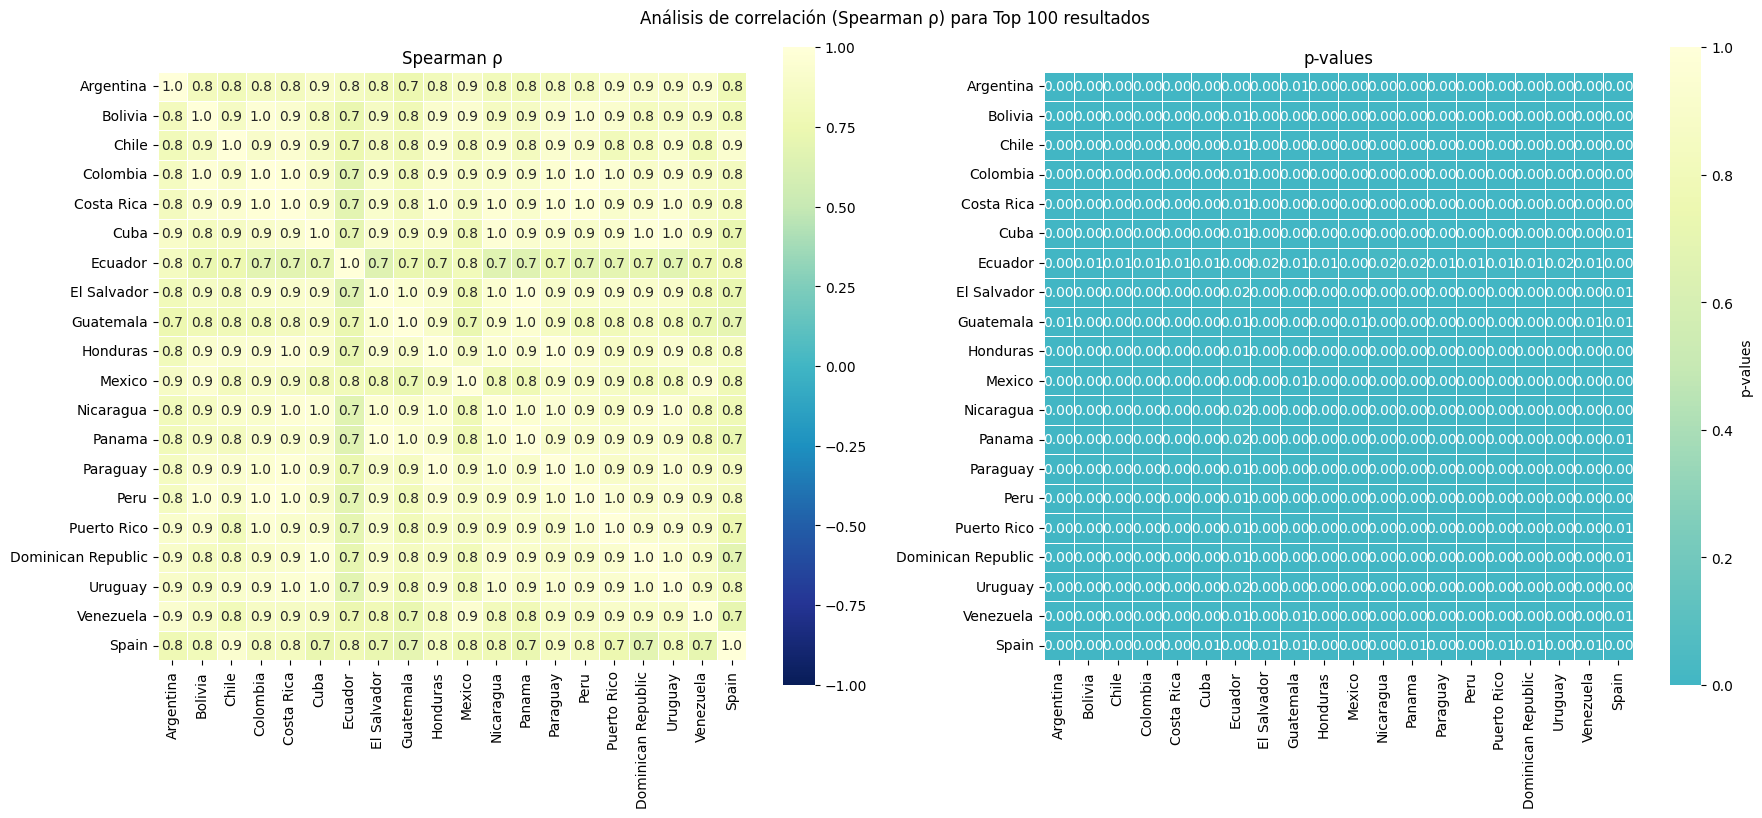

In [30]:
method = "spearman"  # "spearman" o "kendall"

for top in [10, 20, 50, 100]:
    if top == 100:
        rho, p, aligned = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top", only_common=True, common_by_order=False)
    else:
        rho, p, _       = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top", only_common=True, common_by_order=False)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
    cbar_kws={"label": method_dict[method]}

    # Heatmap method
    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", vmin=-1, vmax=1, linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )

    axes[0].set_title(method_dict[method])

    # Heatmap p-values
    sns.heatmap(
        p, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".2f", vmin=0, vmax=1, linewidths=0.5, square=True,
        cbar_kws={"label": "p-values"}, ax=axes[1]
    )
    axes[1].set_title("p-values")

    plt.suptitle(f"Análisis de correlación ({method_dict[method]}) para Top {top} resultados")
    plt.tight_layout()
    plt.show()


In [31]:
'''
https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las
https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica
https://www.interpol.int/es/Delitos/Corrupcion
https://dle.rae.es/corrupci%C3%B3n
https://www.unodc.org/newsletter/es/200601/page004.html
'''
aligned

{'Argentina': [2, 3, 4, 5, 6, 16, 29, 34, 40, 44, 50, 61],
 'Bolivia': [2, 5, 3, 6, 4, 80, 7, 26, 19, 23, 85, 33],
 'Chile': [1, 6, 5, 2, 7, 58, 28, 8, 56, 47, 63, 43],
 'Colombia': [2, 4, 3, 5, 6, 56, 7, 30, 26, 10, 79, 44],
 'Costa Rica': [1, 3, 2, 4, 5, 44, 7, 25, 39, 14, 53, 31],
 'Cuba': [2, 3, 4, 5, 6, 26, 7, 24, 32, 9, 27, 29],
 'Ecuador': [1, 6, 2, 7, 4, 38, 58, 22, 42, 90, 48, 57],
 'El Salvador': [2, 3, 4, 5, 6, 54, 7, 28, 30, 10, 26, 33],
 'Guatemala': [2, 3, 4, 6, 5, 63, 9, 31, 46, 33, 7, 38],
 'Honduras': [2, 3, 4, 6, 5, 65, 7, 28, 36, 29, 61, 32],
 'Mexico': [2, 5, 3, 7, 4, 38, 6, 37, 24, 54, 84, 47],
 'Nicaragua': [2, 3, 4, 5, 6, 40, 7, 34, 50, 12, 37, 36],
 'Panama': [2, 3, 4, 5, 6, 51, 7, 30, 33, 10, 26, 34],
 'Paraguay': [2, 4, 5, 8, 7, 47, 26, 28, 41, 30, 54, 34],
 'Peru': [2, 4, 3, 5, 6, 69, 8, 30, 26, 12, 76, 45],
 'Puerto Rico': [2, 3, 4, 5, 7, 24, 8, 26, 23, 12, 29, 34],
 'Dominican Republic': [2, 4, 3, 5, 6, 26, 9, 28, 41, 14, 29, 30],
 'Uruguay': [2, 3, 5, 4, 6

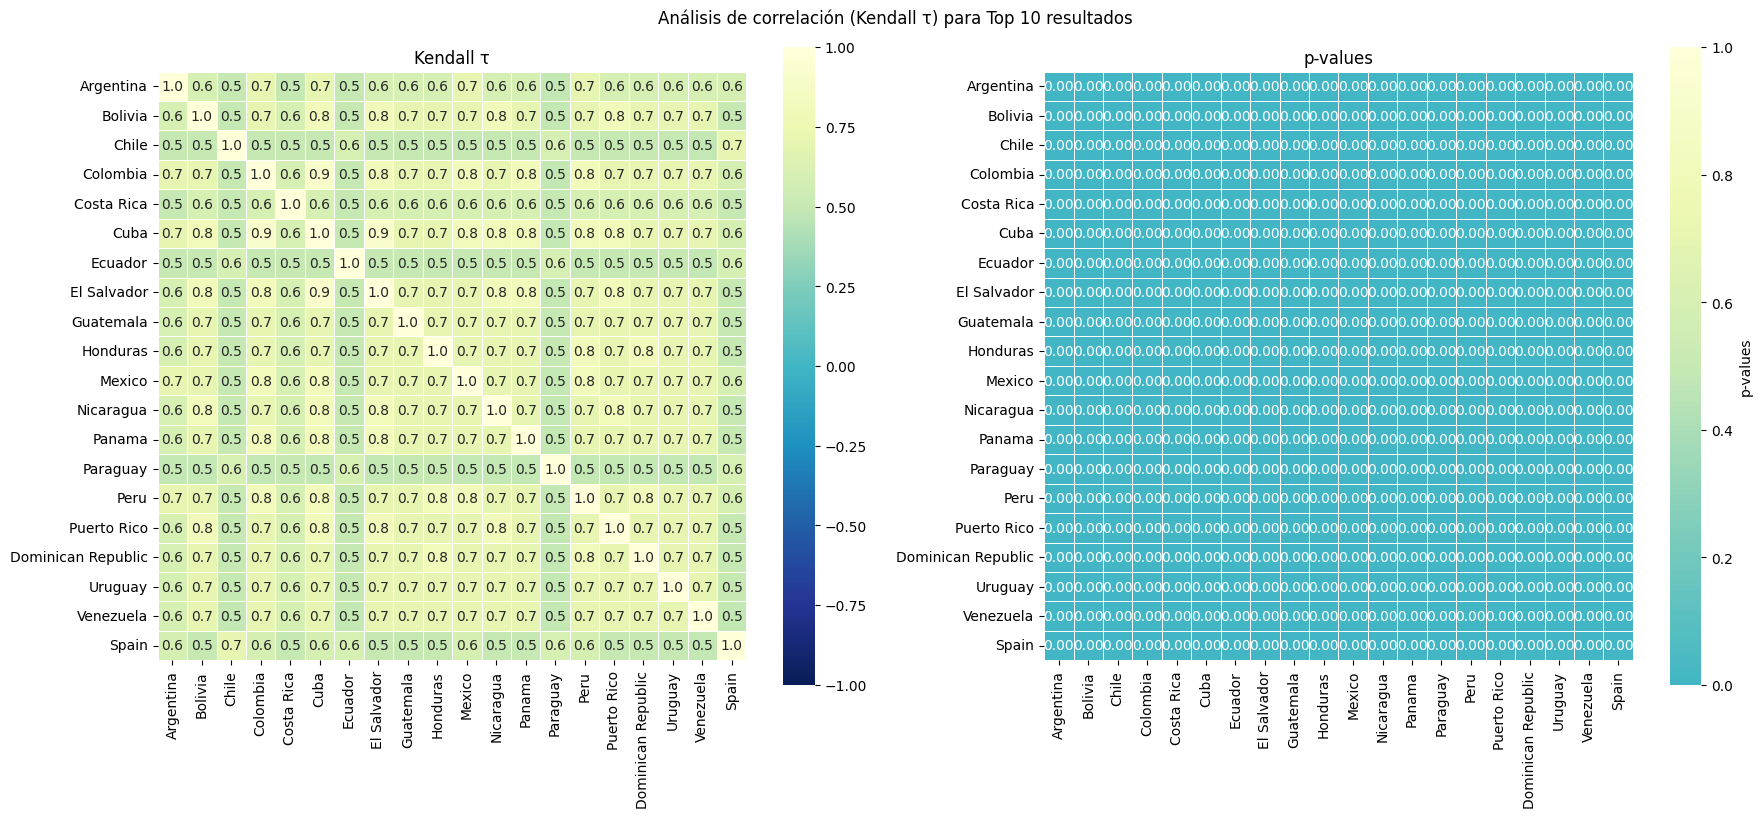

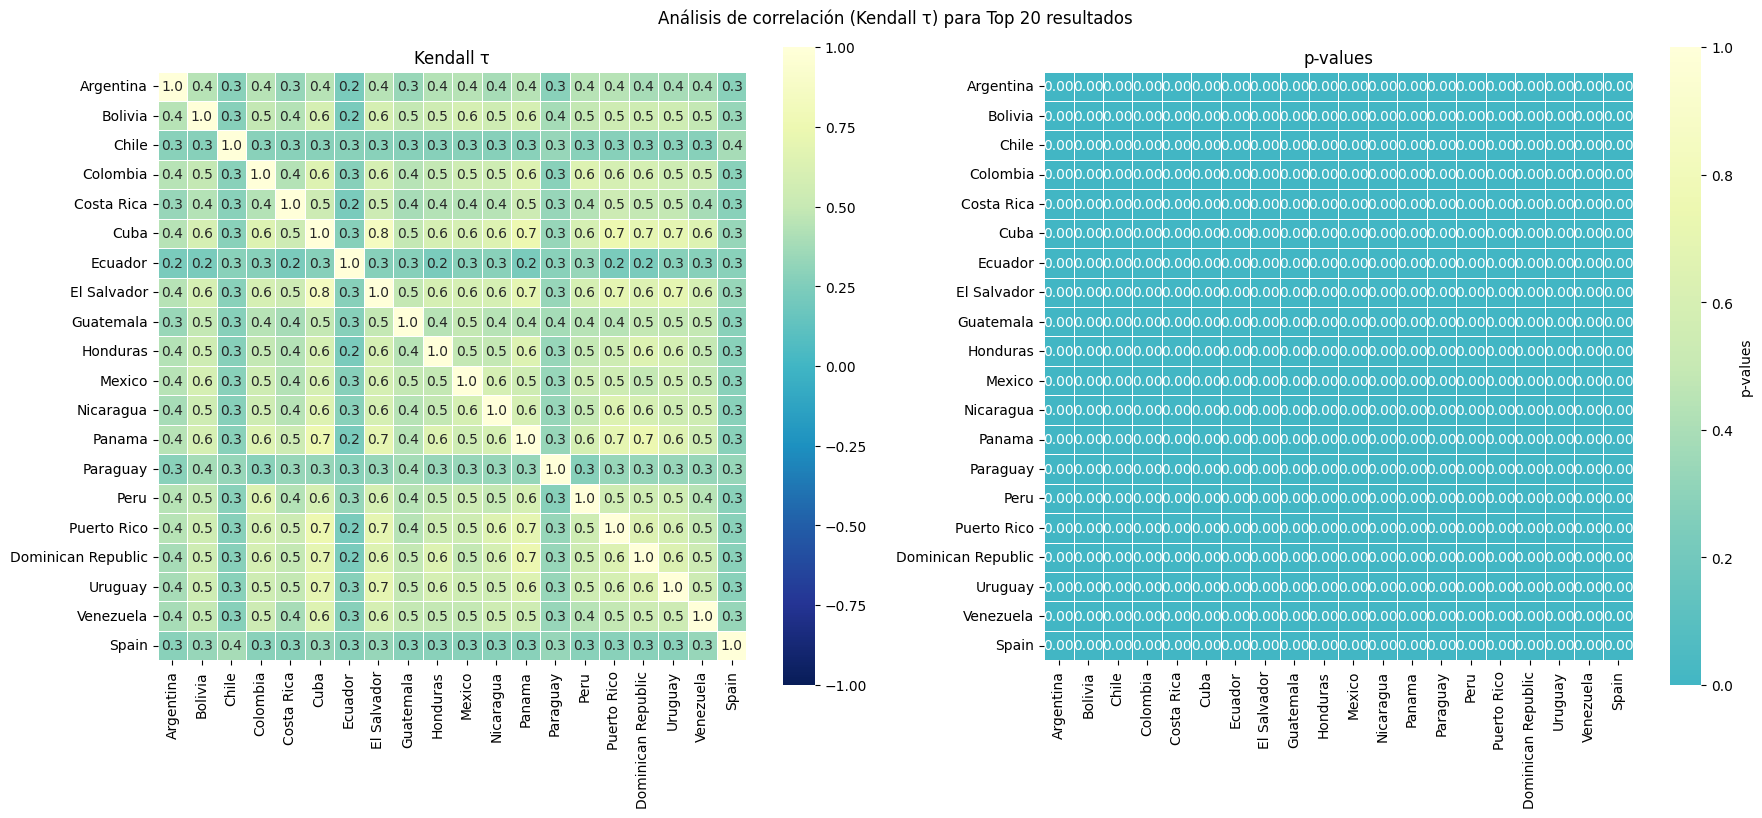

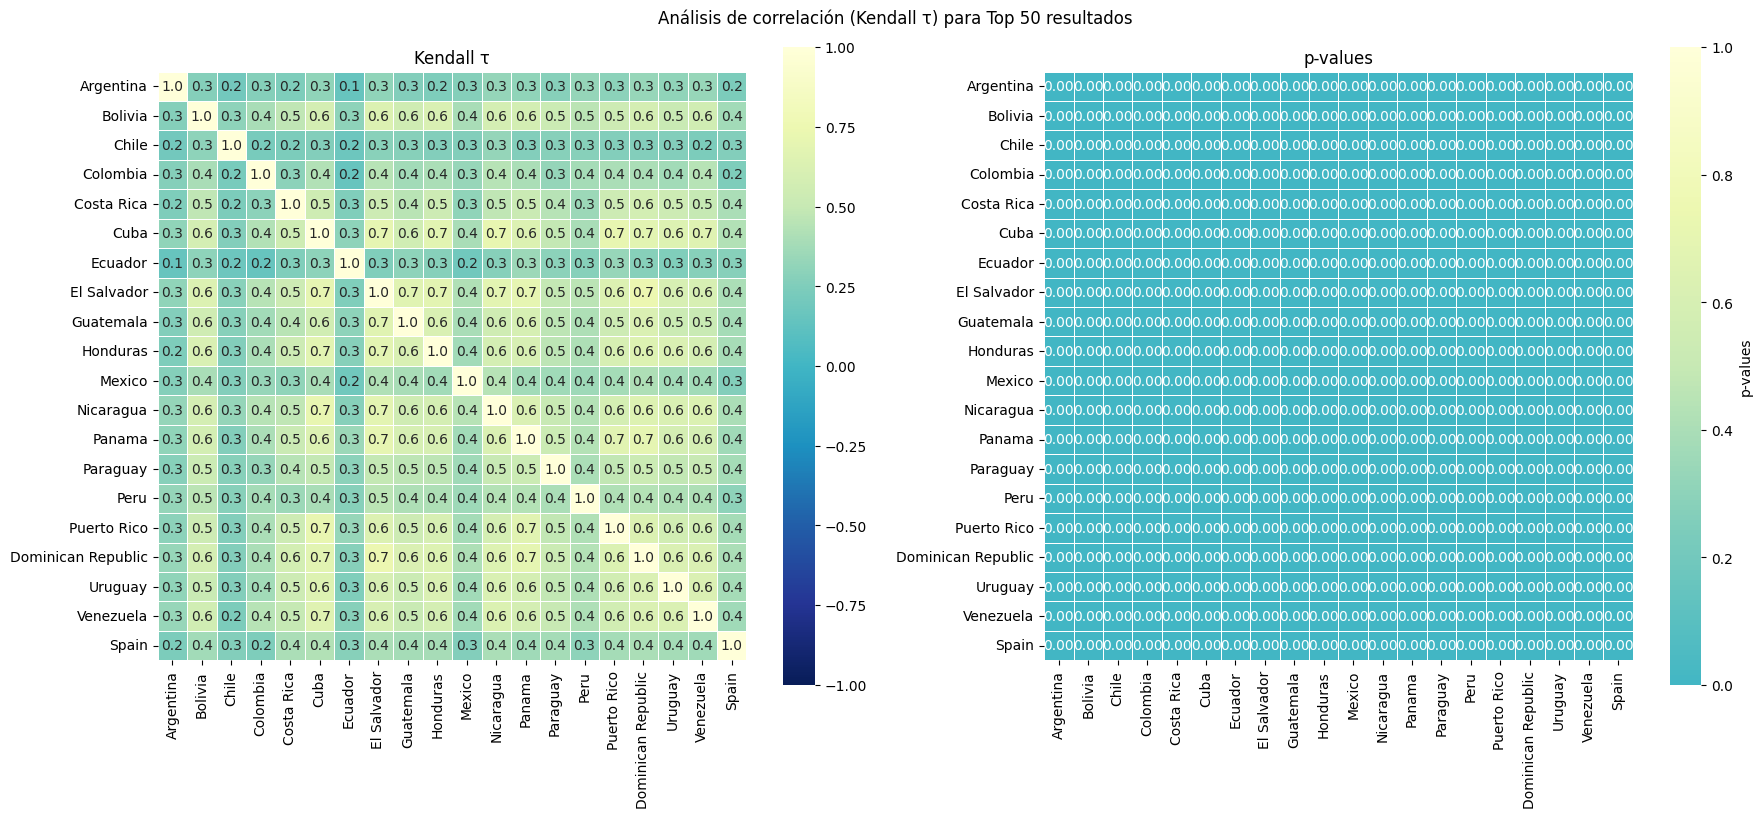

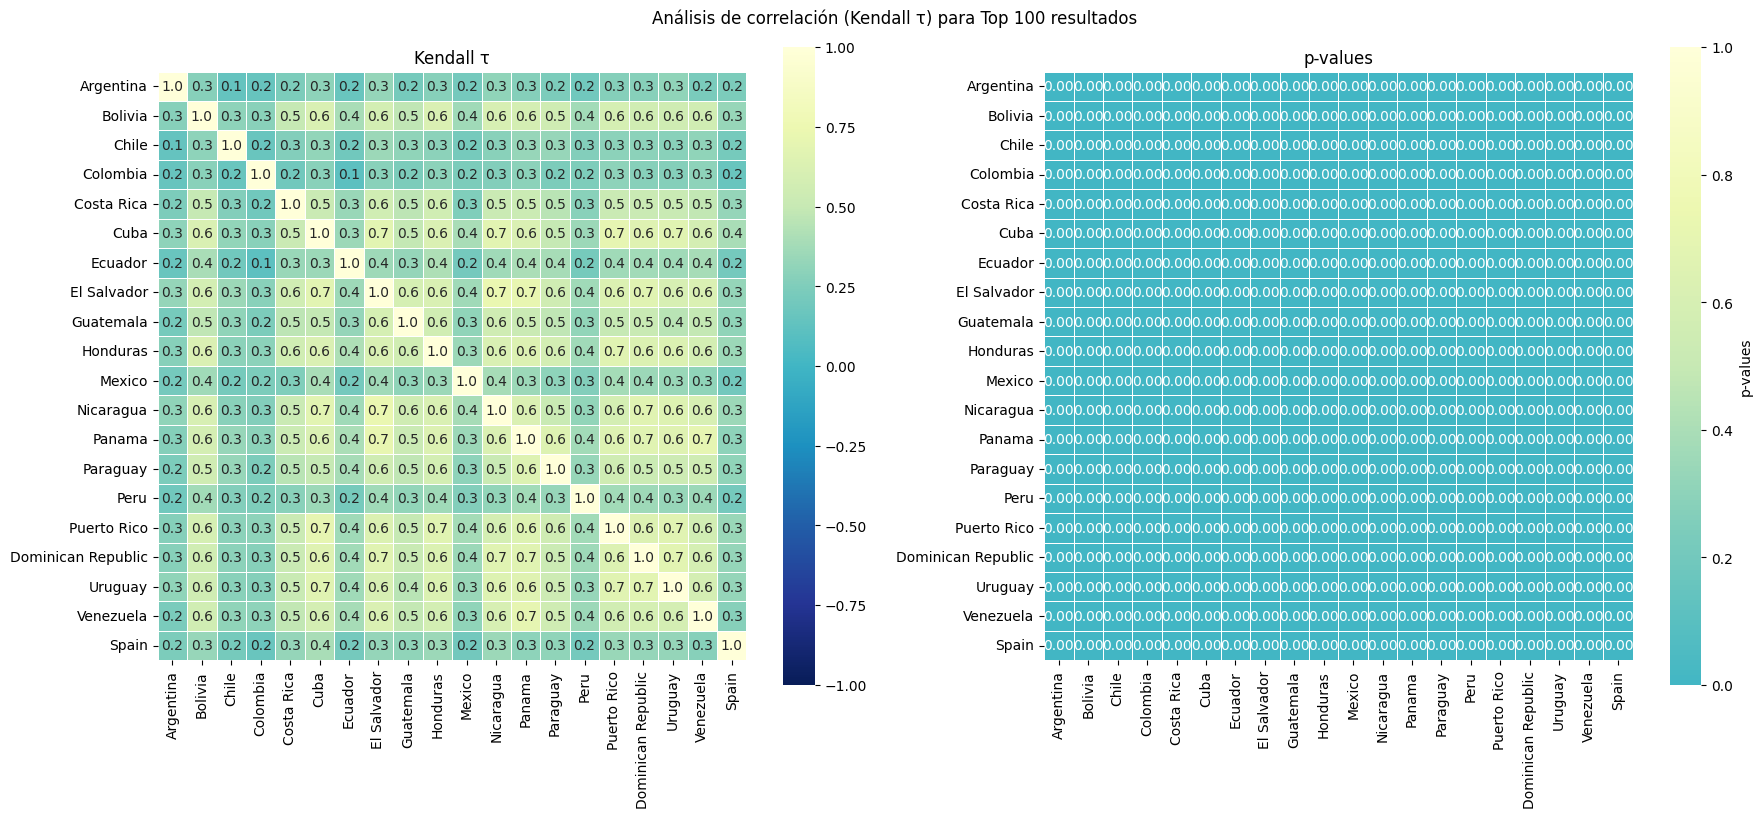

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

method = "kendall"  # "spearman" o "kendall"

for top in [10, 20, 50, 100]:
    rho, p, _ = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top")

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
    cbar_kws={"label": method_dict[method]}

    # Heatmap method
    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", vmin=-1, vmax=1, linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )

    axes[0].set_title(method_dict[method])

    # Heatmap p-values
    sns.heatmap(
        p, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".2f", vmin=0, vmax=1, linewidths=0.5, square=True,
        cbar_kws={"label": "p-values"}, ax=axes[1]
    )
    axes[1].set_title("p-values")

    plt.suptitle(f"Análisis de correlación ({method_dict[method]}) para Top {top} resultados")
    plt.tight_layout()
    plt.show()


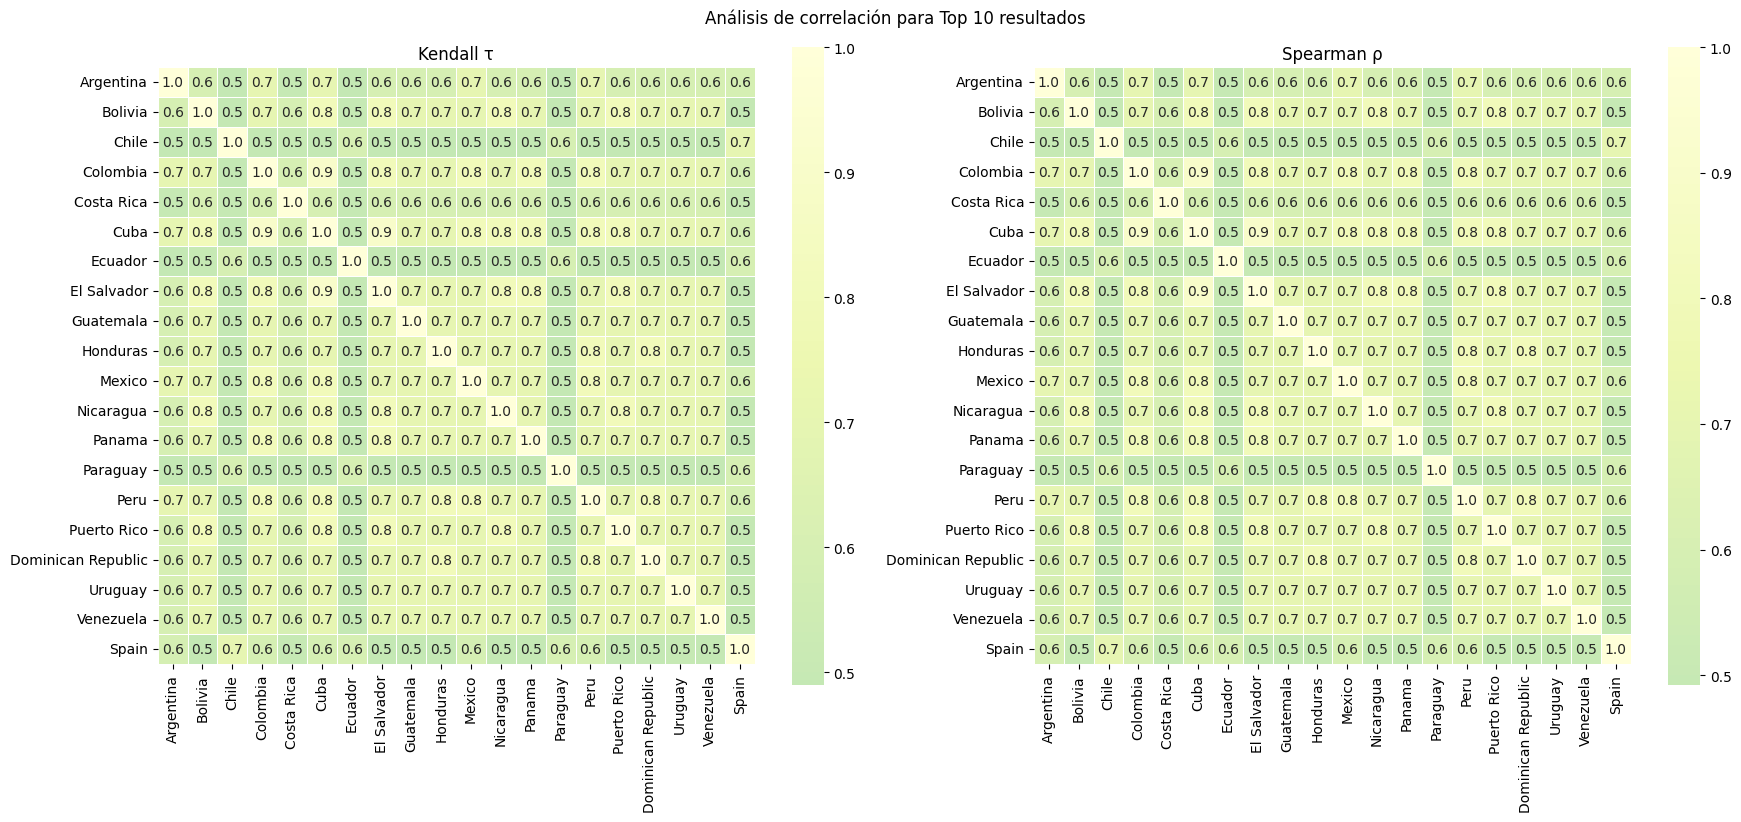

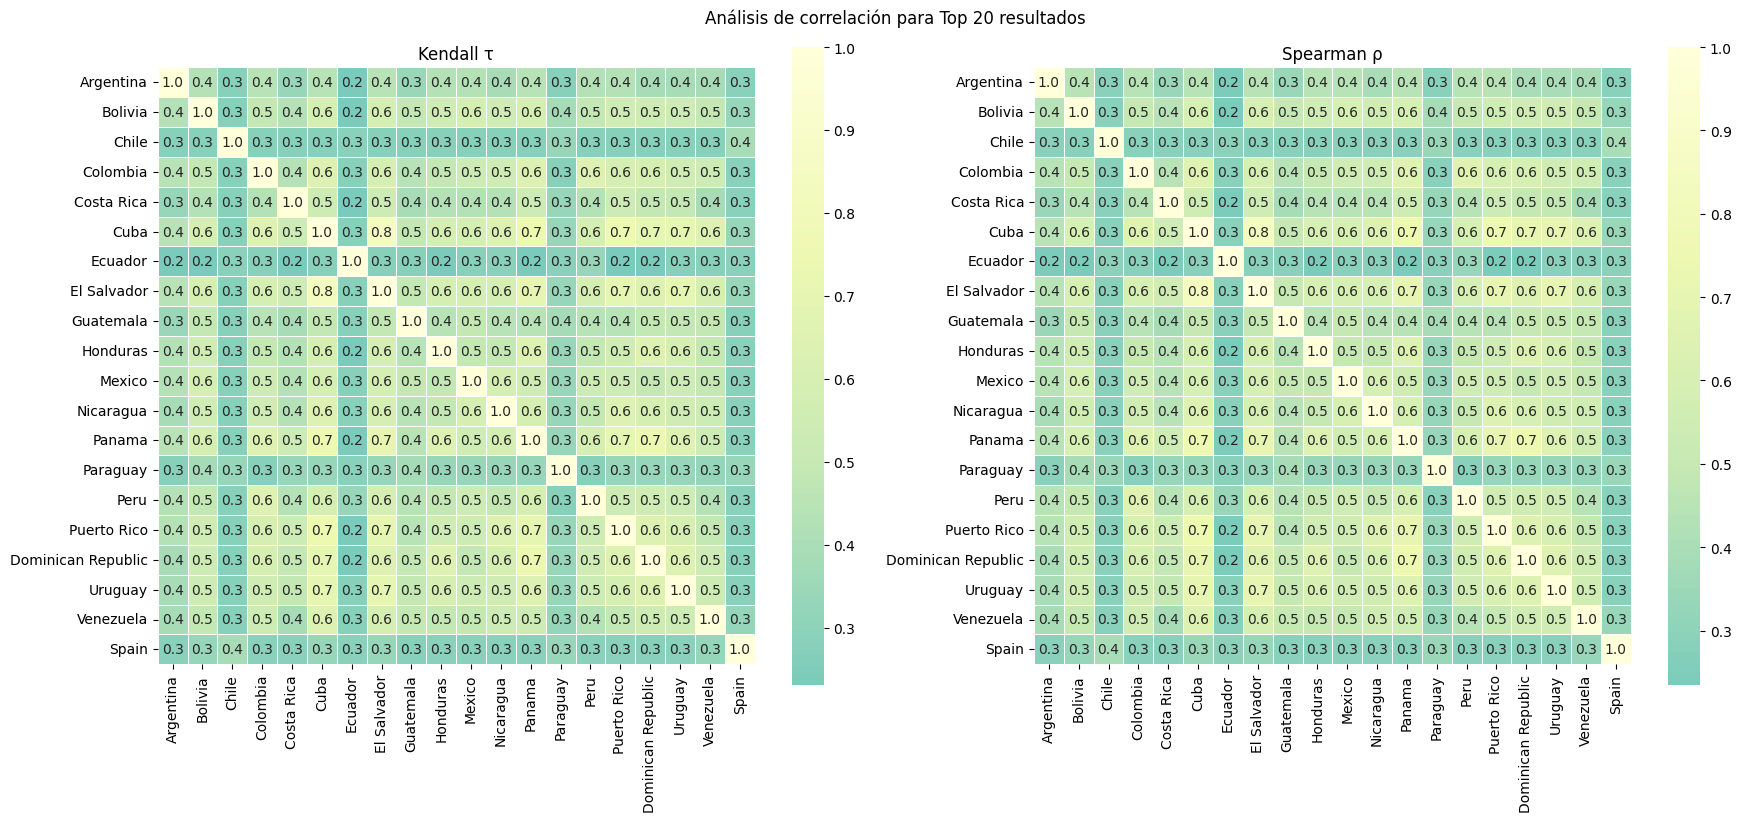

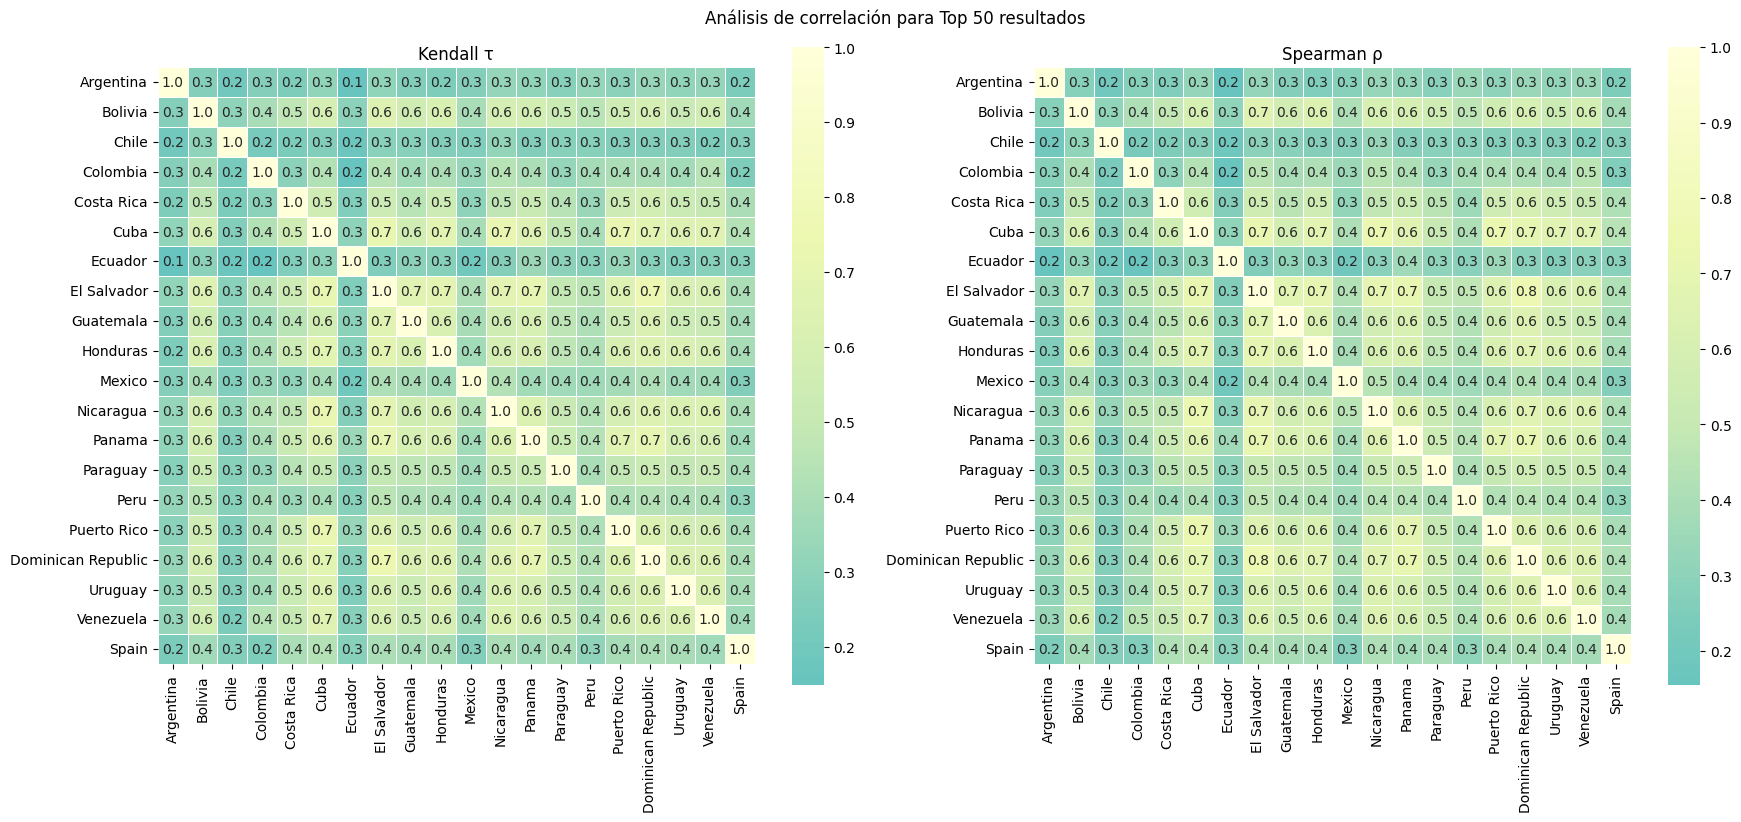

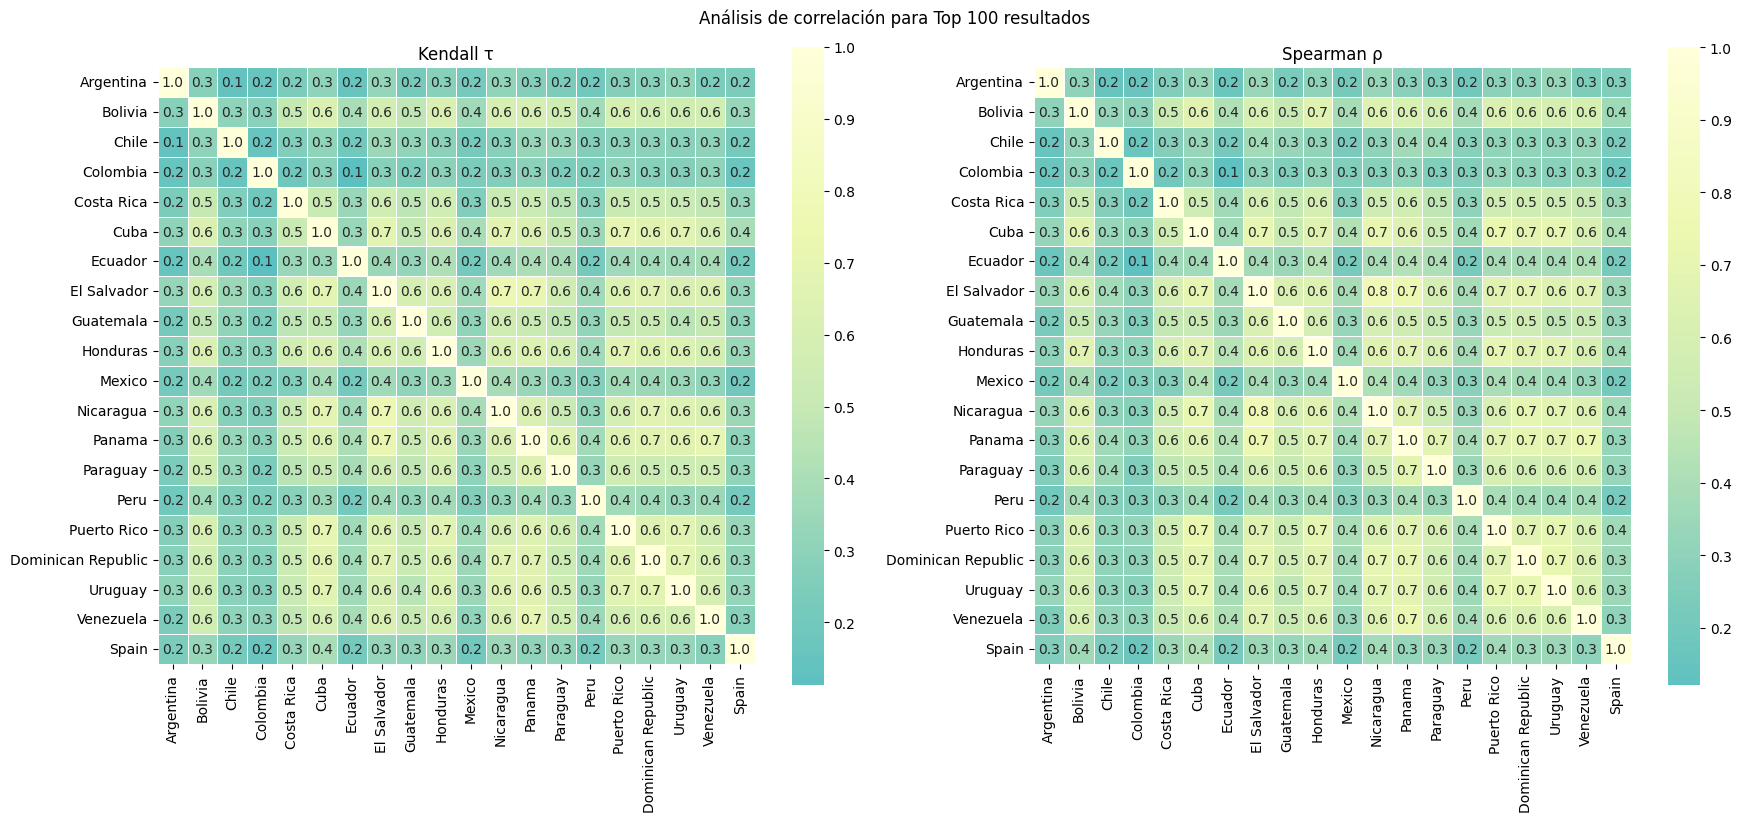

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
cbar_kws={"label": method_dict[method]}

for top in [10, 20, 50, 100]:
    rho, _, _ = correlation_matrix(resultados, all_hrefs, top, method="spearman", absent_policy="1.5top")
    tau, _, _ = correlation_matrix(resultados, all_hrefs, top, method="kendall", absent_policy="1.5top")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    sns.heatmap(
        tau, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )
    axes[0].set_title(method_dict['kendall'])

    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", linewidths=0.5, square=True,
        **cbar_kws, ax=axes[1]
    )

    axes[1].set_title(method_dict['spearman'])

    plt.suptitle(f"Análisis de correlación para Top {top} resultados")
    plt.tight_layout()
    plt.show()


# Kendall W

In [16]:
from itertools import groupby
from math import isfinite
from scipy.stats import chi2
import numpy as np

In [17]:
def kendalls_w_from_matrix(R):
    R = np.asarray(R, dtype=float)
    if R.ndim != 2:
        raise ValueError("R must be a 2D array (m x n).")
    m, n = R.shape

    Rj = R.sum(axis=0)
    Rbar = m * (n + 1) / 2.0
    S = np.sum((Rj - Rbar) ** 2)

    # Tie correction across each judge (row)
    tie_correction = 0.0
    for j in range(m):
        vals, counts = np.unique(R[j, :], return_counts=True)
        tie_correction += np.sum(counts**3 - counts)

    denom = (m**2) * (n**3 - n) - m * tie_correction
    if denom <= 0:
        return {"W": 0.0, "chi2": 0.0, "dof": n - 1, "p_value": 1.0,
                "S": float(S), "denominator": float(denom), "tie_correction": float(tie_correction)}

    W = 12.0 * S / denom
    chi2_stat = m * (n - 1) * W
    dof = n - 1
    from scipy.stats import chi2
    p_value = chi2.sf(chi2_stat, dof)

    return {"W": float(W), "chi2": float(chi2_stat), "dof": int(dof), "p_value": float(p_value),
            "S": float(S), "denominator": float(denom), "tie_correction": float(tie_correction)}

def kendalls_w_on_rankings(rankings_dict, absent_policy="max_plus_one", top=None):
    judges = list(rankings_dict.keys())
    universe = sorted(set().union(*rankings_dict.values()))
    ranks = []
    for j in judges:
        ordered = [{"href": h} for h in rankings_dict[j][: (top or len(rankings_dict[j]))]]
        ranks.append(build_aligned_ranks(ordered, universe, top or len(universe), absent_policy=absent_policy))
    R = np.vstack(ranks)
    res = kendalls_w_from_matrix(R)
    return res, R, judges, universe

# Example
rankings_example = {
    "Argentina": ["a.com", "b.com", "c.com", "d.com"],
    "Mexico":    ["b.com", "a.com", "e.com", "c.com"],
    "Spain":     ["a.com", "c.com", "f.com", "g.com"],
    "Chile":     ["h.com", "a.com", "c.com", "b.com"]
}

res, R, judges, universe = kendalls_w_on_rankings(rankings_example, absent_policy="max_plus_one", top=None)



In [18]:
import kendall_w as kw

top = 100
countries = [c["country"] for c in resultados]
aligned = {
    c["country"]: build_aligned_ranks(
        c["search_results"]["results"][:top], all_hrefs, top, absent_policy="1.5top"
    )
    for c in resultados
}

In [19]:
kw.compute_w(list(aligned.values()))

0.0001837679221158374

In [20]:
common = get_common(resultados, 100)
common

{'https://cnc.gob.gt/',
 'https://dle.rae.es/corrupci%C3%B3n',
 'https://dpej.rae.es/lema/corrupci%C3%B3n',
 'https://elpais.com/noticias/corrupcion/',
 'https://es.wikipedia.org/wiki/Corrupci%C3%B3n_pol%C3%ADtica',
 'https://publications.iadb.org/publications/spanish/document/Corrupci%C3%B3n-normal-y-corrupci%C3%B3n-sist%C3%A9mica.pdf',
 'https://www.interpol.int/es/Delitos/Corrupcion',
 'https://www.ohchr.org/es/good-governance/corruption-and-human-rights',
 'https://www.unir.net/revista/derecho/que-es-corrupcion/',
 'https://www.unir.net/revista/derecho/que-es-corrupcion/#:~:text=Etimol%C3%B3gicamente%2C%20el%20vocablo%20corrupci%C3%B3n%20proviene,al%20sistema%20social%20o%20a%20las',
 'https://www.unodc.org/newsletter/es/200601/page004.html',
 'https://www.youtube.com/watch?v=Be3q1GSMhf8'}